# TEST EAE-OPERAS

Análisis resultados test EAE y OPERAS.

# IMPORTAR LIBRERIAS

In [1]:
#Importamos librerias necesarias. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import matplotlib.ticker as mticker
from scipy.stats import levene
import math as mt
import pingouin as pg


import warnings
warnings.filterwarnings('ignore')
# Definir el estilo de matplotlib
plt.style.use('seaborn-v0_8-whitegrid')

C:\Users\OT\AppData\Local\Temp\ipykernel_4612\2027980481.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# CARGAR DATOS

El test EAE y OPERAS comparteixen arxiu de text .xlsx. Les columnes de la A a la Y apliquem ambdós test, fan referencia a variables explicatives y la resta esta dividit com:
- Test OPERAS: columnes Z a EO (columna 25 a 146): el cálcul d'aquest test es realitzarà a través de l'aplicació web
- Test EAE: columnes ER a WL (columna 147 a 611)

In [2]:
#Archivo con los resultados de ambos tests OPERAS y EAE
archivo='./Datasets/TRABAJO DE FIN DE GRADO. (1-154)_v2.xlsx'
#Archivo con los resultados del test de personalitat OPERAS
archivo2='./Datasets/TEST OPERAS FET_v2.xlsx'

In [3]:
#Descargamos los datos de ambós archivos en una variable como un dataframe. 
data_eae=pd.read_excel(archivo)
data_operas=pd.read_excel(archivo2)

In [4]:
#Comprobamos que ambos archivos contengan el mismo número de registros o individuos, dado que se aplican al mismo grupo. 
print(f'Individuos test EAE: {len(data_eae)}\nIndividuos test OPERAS: {len(data_operas)}')

Individuos test EAE: 154
Individuos test OPERAS: 154


# LIMPIEZA DATOS

Primero trabajaremos sobre el Test EAE. Al cargar el archivo .xlsx como 'archivo', se observan columnas que no aportan valor al análisis. Además, las columnas que no corresponden a este test, las correspondientes a OPEREAS, se procede a eliminarlas. Estas columnas se eliminan para este análisis pero no del archivo original.

In [5]:
#Eliminar las siguientes columnas: de la 25 a la 146 correspondientes al test OPERAS, el resto son columnas que no aportan valor.
data_eae.drop(data_eae.columns[[2,3,4,5,6,7,9,10,12,13,15,16,18,19,21,22,23,24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146]],axis=1,inplace=True)


#Eliminar las columnas que contengan las palabras 'Comentaris' y 'Punts' son columnas sin datos.
filtros=['Comentaris','Punts']

for filtro in filtros:
    columnas_a_eliminar=[col for col in data_eae.columns if filtro in col]
    data_eae=data_eae.drop(columns=columnas_a_eliminar)

In [6]:
#Eliminamos espacios delante y detrás del texto que conforma el nombre de las columnas
data_eae.columns=data_eae.columns.str.strip()

# Función para eliminar \xa0 de una cadena
def eliminar_espacios_no_separables(valor):
    if isinstance(valor, str): #isinstance sirve para indicar que entre en el bucle solo si es un string
        return valor.replace('\xa0', '').replace('\n', '')
    return valor

# Aplicar la función a cada valor del DataFrame
data_eae = data_eae.applymap(eliminar_espacios_no_separables)

La escala G de EAE va dirigida a individuos entre 18-60 años de edad ambos inclusive. Consta de 53 ítems distribuidos en 4 grandes dimensiones: salud, relaciones humanas, estilo de vida y asuntos laborales y económicos. El test nos muestra:

- Presencia (SI) o Ausencia (NO) del acontecimiento estresante.
- Intensidad con que se han vivido o se vivien estos sucesos estresantes (0,1,2,3), 0 significada nada, 1 un poco, 2 mucho, 3 muchisimo.
- Continua afectando (A) o no le afecta (P).


Nos tenemos que fijar solo en los SI para evaluar los acontenciomientos estresantes. Con los SI dividimos:
- A: continua afectandolo, notese que en tabla origen el valor de A esta como 'A = Si'. 
- P: no continua afectando, notese que en tabla origen el valor de P esta como 'P = No'.
    
El cálculo se aplica para todas las A con intensidad 1 sumo todos los 1, para todas las A con intensidad 2 sumo todos los 2, el valor asociado es el mismo marcado por la intensidad. Esto aplica también para P. Notese que los valores de intensidad vienen como: 
- '1 = un poco'
- '2 = mucho'
- '3 = muchísimo'

La suma total de A=suma todos los 1, suma todo los 2, suma todos los 3  para tener la intensidad del estrés en el presente y esto igual para P para tener la intensidad del estrés en el pasado. La suma de A+P es la puntuación total nos indica el índice total de intensidad y se debe transformar a centil para comparar los resultados totales y parciales con las medias obtenidas por el grupo normativo de cada escala.
Tambien se puede obtener sabiendo el numero de A o P y multiplicando por el valor promedio de la tabla 3.

In [7]:
# Mapeo de valores a reemplazar. Aquí recorremos el dataframe a partir de la columna 7 incluida.
# Remplazamos todos los valores de intensidad por números enteros.
mapeo_valor_intensidad = {
    '0 = nada':0.,
    '1 = un poco': 1.,
    '2 = mucho': 2.,
    '3 = muchísimo': 3.,
}

for columna in data_eae.columns[7:]:  
    data_eae[columna] = data_eae[columna].replace(mapeo_valor_intensidad)

## TRATAMIENTO VALORES NULLS

Si revisamos valores nulos no encontramos ningún valor nulo en las variables explicativas de referencia para el estudio, excepto la variable 'Cargo que desarrolla en el trabajo' que se trata a continuación. Únicamente se observan valores nulos en los ítems del test pero no son valores nulos erroneos, simplemente es cuando no aplica una respuesta.

In [8]:
# Calcular la suma de valores nulos en cada columna
valores_nulos_por_columna = data_eae.isna().sum()

# Filtrar solo las columnas con valores nulos
columnas_con_nulos = valores_nulos_por_columna[valores_nulos_por_columna > 0]

# Mostrar las columnas con valores nulos
print(columnas_con_nulos)

Cargo que desarrolla en el trabajo     71
¿En qué medida le ha afectado?         52
¿Todavía le afecta?                    52
¿En qué medida le ha afectado?        107
¿Todavía le afecta? 2                 107
                                     ... 
¿Todavía le afecta? 51                109
¿En qué medida le ha afectado?462     108
¿Todavía le afecta? 512               108
¿En qué medida le ha afectado?4622    148
¿Todavía le afecta? 5122              148
Length: 107, dtype: int64


Únicamente encontramos valores nulos en la columna 'Cargo que desarrolla en el trabajo' dado que Estudiantes y Desempleados no han dado respuesta. 

# ANÁLISIS EXPLORATORIO DE DATOS (EDA)

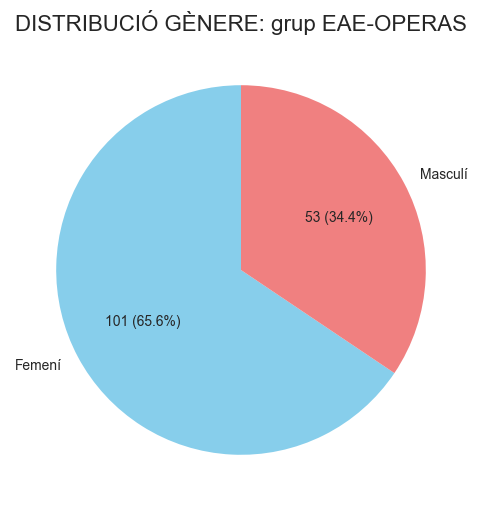

In [9]:
# Calcular la distribución de la columna categórica
distribucion = data_eae['Género'].value_counts()
etiqueta_gen=['Femení','Masculí']
# Crear un gráfico de pastel
plt.figure(figsize=(8, 6))
plt.pie(distribucion, labels=etiqueta_gen, autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * sum(distribucion) / 100, p), 
        startangle=90,colors=['skyblue', 'lightcoral'])

#El atributo autopct es para definir el texto de cada quesito. Cona la función lambda y p, con p estamos dando el porcentaje.. 
#..como entrada a la función lambda. Después definimos primero el formato y después el valor que queremos mostrar. Por ejemplo..
#.. '{:.0f}'' número decimal con 0 decimales y 'p * sum(distribucion) / 100' frecuencia absoluta de la distribución. 

#El atributo startangle: define desde donde se inicia la primera porción, el ángulo.

# Añadir título
plt.title('DISTRIBUCIÓ GÈNERE: grup EAE-OPERAS',fontsize=16)
plt.show()

In [10]:
data_eae['Edad'].unique()

array(['18 - 25', '46 - 55', '26 - 35', '56 - 64', '36 - 45', '+ 65'],
      dtype=object)

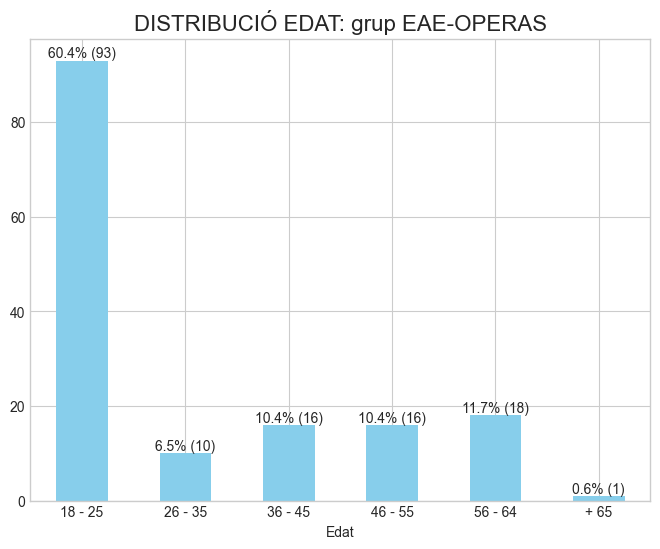

In [11]:
# Calcular la distribución de la columna categórica
distribucion = data_eae['Edad'].value_counts()

# Lista de edades en el orden deseado
lista_edad = ['18 - 25', '26 - 35', '36 - 45', '46 - 55', '56 - 64','+ 65']

# Calcular la distribución de la columna categórica y ordenar según lista_edad
distribucion = data_eae['Edad'].value_counts().reindex(lista_edad)

# Crear un gráfico de barras
plt.figure(figsize=(8, 6))
ax = distribucion.plot(kind='bar', color='skyblue')

# Añadir porcentaje encima de cada barra
for p in ax.patches: #ax.patches itera sobre cada parche o barra
    ax.annotate(f'{p.get_height()/len(data_eae)*100:.1f}% ({p.get_height()})', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

    #p.get_height():altura de la barra o nombre d'observacions per cada categoria.
    #(p.get_x() + p.get_width() / 2., p.get_height()): indica la posició on va situat cada text o en aquest cas, percentatge.
    #ha='center': centra el text horizontalment sobre la barra.
    #va='bottom': alinea el text a la part superior de la barra deixant un marge.

# Añadir título y etiquetas
plt.title('DISTRIBUCIÓ EDAT: grup EAE-OPERAS',fontsize=16)
plt.xlabel('Edat')
plt.xticks(rotation=0) # Aquí puedes ajustar el ángulo de rotación, 0 grados mantendrá las etiquetas horizontales

# Mostrar el gráfico
plt.show()

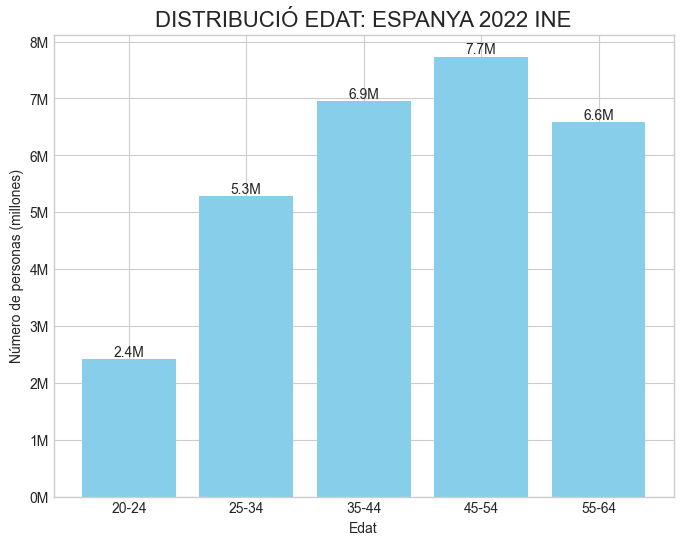

In [12]:
x = ['20-24', '25-34', '35-44', '45-54', '55-64']
y = [2416033, 5277574, 6948723, 7736861, 6581568]
bar_labels = ['20-24', '25-34', '35-44', '45-54', '55-64']

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar las barras
bars = ax.bar(x, y, color='skyblue')

# Añadir porcentaje encima de cada barra
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2., height,
        f'{height / 1e6:.1f}M',  # Convertir a millones y formatear
        ha='center', va='bottom'
    )

# Añadir título y etiquetas
ax.set_title('DISTRIBUCIÓ EDAT: ESPANYA 2022 INE', fontsize=16)
ax.set_xlabel('Edat')
ax.set_ylabel('Número de personas (millones)')
ax.set_xticklabels(x, rotation=0)  # Ajustar el ángulo de rotación de las etiquetas

# Formatear el eje Y para mostrar números en millones
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{int(x / 1e6)}M'))

# Mostrar el gráfico
plt.show()


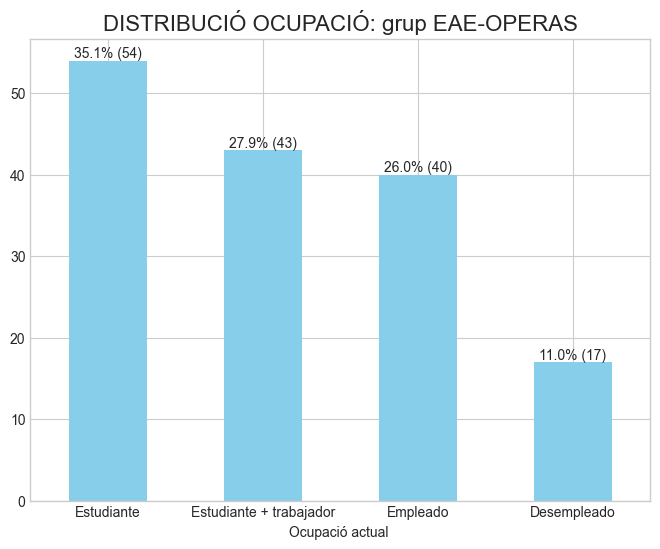

In [13]:
# Calcular la distribución de la columna categórica
distribucion2 = data_eae['Ocupación actual'].value_counts()

# Crear un gráfico de barras
plt.figure(figsize=(8, 6))


ax2 = distribucion2.plot(kind='bar', color='skyblue')

# Añadir porcentaje encima de cada barra
for p in ax2.patches: #ax.patches itera sobre cada parche o barra
    ax2.annotate(f'{p.get_height()/len(data_eae)*100:.1f}% ({p.get_height()})', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

# Añadir título y etiquetas
plt.title('DISTRIBUCIÓ OCUPACIÓ: grup EAE-OPERAS',fontsize=16)
plt.xlabel('Ocupació actual ')
plt.xticks(rotation=0) 
# Mostrar el gráfico
plt.show()

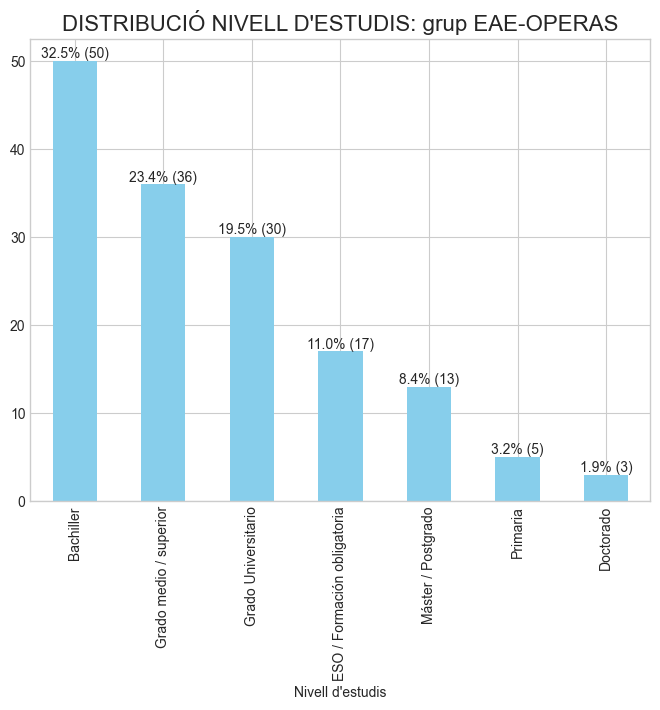

In [14]:
distribucion3 = data_eae['Nivel de estudios logrados'].value_counts()

# Crear un gráfico de barras
plt.figure(figsize=(8, 6))
ax3 = distribucion3.plot(kind='bar', color='skyblue')

# Añadir porcentaje y frecuencia encima de cada barra
for p in ax3.patches: # ax.patches itera sobre cada parche o barra
    porcentaje = p.get_height() / len(data_eae) * 100
    frecuencia = p.get_height()
    ax3.annotate(f'{porcentaje:.1f}% ({frecuencia})', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom')

# Añadir título y etiquetas
plt.title("DISTRIBUCIÓ NIVELL D'ESTUDIS: grup EAE-OPERAS",fontsize=16)
plt.xlabel("Nivell d'estudis")
plt.xticks(rotation=90) # Rotar las etiquetas del eje x si es necesario

# Mostrar el gráfico
plt.show()

In [15]:
data_eae['Nivel de estudios logrados'].unique()

array(['Grado Universitario', 'Grado medio / superior', 'Bachiller',
       'Máster / Postgrado', 'Doctorado', 'ESO / Formación obligatoria',
       'Primaria'], dtype=object)

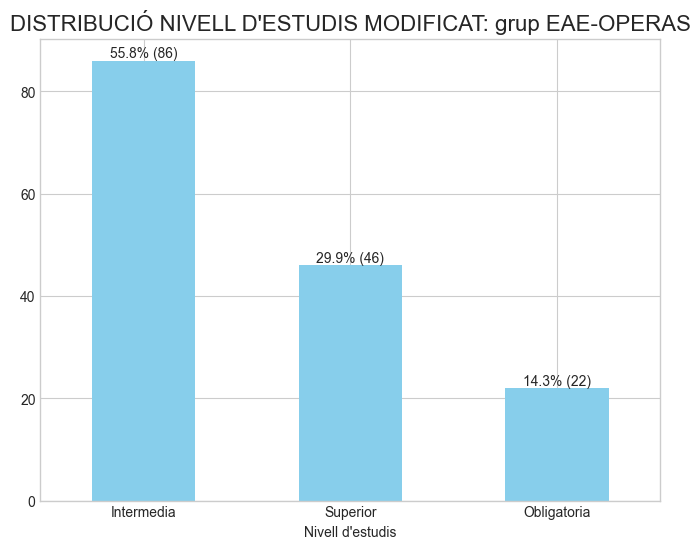

In [16]:
data_eae['Nivel de estudios logrados 2'] = data_eae['Nivel de estudios logrados'].copy()
data_eae['Nivel de estudios logrados 2'] = data_eae['Nivel de estudios logrados 2'].replace({
                                                    'Grado Universitario': 'Superior', 
                                                    'Grado medio / superior': 'Intermedia',
                                                    'Bachiller':'Intermedia',
                                                    'Máster / Postgrado':'Superior',
                                                    'Doctorado':'Superior',
                                                    'ESO / Formación obligatoria':'Obligatoria',
                                                    'Primaria':'Obligatoria'})


distribucion3 = data_eae['Nivel de estudios logrados 2'].value_counts()

# Crear un gráfico de barras
plt.figure(figsize=(8, 6))
ax3 = distribucion3.plot(kind='bar', color='skyblue')

# Añadir porcentaje y frecuencia encima de cada barra
for p in ax3.patches: # ax.patches itera sobre cada parche o barra
    porcentaje = p.get_height() / len(data_eae) * 100
    frecuencia = p.get_height()
    ax3.annotate(f'{porcentaje:.1f}% ({frecuencia})', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom')

# Añadir título y etiquetas
plt.title("DISTRIBUCIÓ NIVELL D'ESTUDIS MODIFICAT: grup EAE-OPERAS", fontsize=16)
plt.xlabel("Nivell d'estudis")
plt.xticks(rotation=0) # Rotar las etiquetas del eje x si es necesario

# Mostrar el gráfico
plt.show()

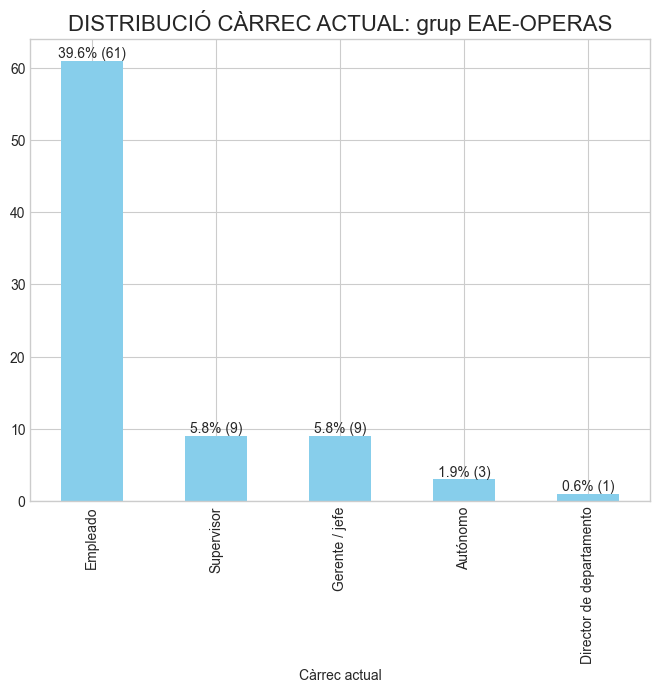

In [17]:
# Calcular la distribución de la columna categórica
distribucion4 = data_eae['Cargo que desarrolla en el trabajo'].value_counts()

# Crear un gráfico de barras
plt.figure(figsize=(8, 6))
ax4 = distribucion4.plot(kind='bar', color='skyblue')

# Añadir porcentaje y valor de frecuencia encima de cada barra
for p in ax4.patches:
    ax4.annotate(f'{p.get_height()/len(data_eae)*100:.1f}% ({p.get_height()})', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom')

# Añadir título y etiquetas
plt.title('DISTRIBUCIÓ CÀRREC ACTUAL: grup EAE-OPERAS',fontsize=16)
plt.xlabel('Càrrec actual')
plt.xticks(rotation=90) 

# Mostrar el gráfico
plt.show()

In [18]:
data_eae['Cargo que desarrolla en el trabajo'].unique()

array([nan, 'Empleado', 'Supervisor', 'Gerente / jefe', 'Autónomo',
       'Director de departamento'], dtype=object)

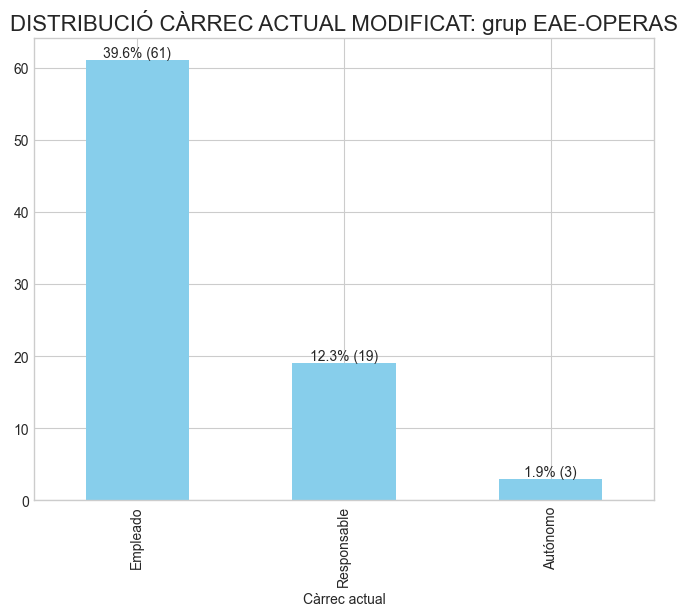

In [19]:
data_eae['Cargo que desarrolla en el trabajo 2'] = data_eae['Cargo que desarrolla en el trabajo'].copy()
data_eae['Cargo que desarrolla en el trabajo 2'] = data_eae['Cargo que desarrolla en el trabajo 2'].replace({
                                                    'Desempleado': 'Desempleado',
                                                    'Estudiante': 'Estudiante',    
                                                    'Empleado': 'Empleado',
                                                    'Autónomo':'Autónomo','Director de departamento':'Responsable',
                                                    'Supervisor':'Responsable',
                                                    'Gerente / jefe':'Responsable'})

# Calcular la distribución de la columna categórica
distribucion4 = data_eae['Cargo que desarrolla en el trabajo 2'].value_counts()

# Crear un gráfico de barras
plt.figure(figsize=(8, 6))
ax4 = distribucion4.plot(kind='bar', color='skyblue')

# Añadir porcentaje y valor de frecuencia encima de cada barra
for p in ax4.patches:
    ax4.annotate(f'{p.get_height()/len(data_eae)*100:.1f}% ({p.get_height()})', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom')

# Añadir título y etiquetas
plt.title('DISTRIBUCIÓ CÀRREC ACTUAL MODIFICAT: grup EAE-OPERAS',fontsize=16)
plt.xlabel('Càrrec actual')
plt.xticks(rotation=90) 

# Mostrar el gráfico
plt.show()

# CÁLCULO EAE

In [20]:
# Generar nuevas columnas para acumular puntuaciones, inicializamos con valor 0.
lista_columnas_intensidad=['P=0.0','P=1.0','P=2.0','P=3.0','A=0.0','A=1.0','A=2.0','A=3.0']

for columna in lista_columnas_intensidad:
    data_eae[columna]=0


In [21]:
"""
Iteramos sobre todas las columnas del dataframe a partir de la columna 7 incluida y con un paso de cada 3. Se aplica este paso
porque un bloque de 3 columnas conforma todo el conjunto del ítem, incluyendo en este orden lo siguiente: 

- Indicación de afectación estrés: SI/NO.
- Indicación intensidad estrés: 0,1,2,3.
- Indicación temporal estrés: P=No

Realiza un sumatorio sobre las nuevas columnas: 'P=0.0','P=1.0','P=2.0','P=3.0','A=0.0','A=1.0','A=2.0','A=3.0' para cada 
registro o individuo.

"""

for columna in range(7, 160, 3):
    # Iterar sobre las filas
    for indice_fila, fila in data_eae.iterrows():
        # Verificar si el valor en la primera columna es "Si"
        
        if fila[data_eae.columns[columna]] == 'Si':
            # Verificar si el valor en la segunda columna está en [0, 1, 2, 3]
            valor_segunda_columna = data_eae.iloc[indice_fila, columna + 1]
            if valor_segunda_columna in [0., 1., 2., 3.]:
                # Verificar si el valor en la tercera columna es "A=Si"
                if fila[data_eae.columns[columna + 2]] == 'A = Si':
                    # Actualizar el DataFrame
                    columna_a_actualizar = f'A={valor_segunda_columna}'
                    # Verificar si la columna existe, si no, crearla
                    data_eae.at[indice_fila, columna_a_actualizar] += 1
                elif fila[data_eae.columns[columna + 2]] == 'P = No':
                    # Actualizar el DataFrame
                    columna_a_actualizar = f'P={valor_segunda_columna}'
                    # Verificar si la columna existe, si no, crearla
                    data_eae.at[indice_fila, columna_a_actualizar] += 1

In [22]:
"""
Creamos tres funciones para tener el sumatorio total de la intensidad en A, P y TOTAL (A+P)
"""
def calcular_total_fila(fila):
    return fila['A=0.0']*0 + fila['A=1.0'] * 1 + fila['A=2.0']*2+ fila['A=3.0']*3

def calcular_total_fila2(fila):
    return fila['P=0.0']*0 + fila['P=1.0'] * 1 + fila['P=2.0']*2+ fila['P=3.0']*3

def total(fila):
    return fila['TOTAL A']+fila['TOTAL P']

# Aplicar la función a cada fila del DataFrame
data_eae['TOTAL A'] = data_eae.apply(calcular_total_fila, axis=1)
data_eae['TOTAL P'] = data_eae.apply(calcular_total_fila2, axis=1)
data_eae['INDICE TOTAL']=data_eae.apply(total, axis=1)

#FRECUENCIA SI
data_eae['Frecuencia_SI']=data_eae['P=0.0']+data_eae['P=1.0']+data_eae['P=2.0']+data_eae['P=3.0']+data_eae['A=0.0']+data_eae['A=1.0']+data_eae['A=2.0']+data_eae['A=3.0']
data_eae['Frecuencia_SI_P']=data_eae['P=0.0']+data_eae['P=1.0']+data_eae['P=2.0']+data_eae['P=3.0']
data_eae['Frecuencia_SI_A']=data_eae['A=0.0']+data_eae['A=1.0']+data_eae['A=2.0']+data_eae['A=3.0']

## TRANSFORMACIÓN PERCENTIL

In [23]:
def encontrar_centil(valor):
    mapeo_centiles = {
        120: 99,
        106: 95,
        85: 90,
        77: 75,
        69: 70,
        62: 65,
        57: 60,
        54: 55,
        51: 50,
        47: 45,
        43: 40,
        40: 35,
        36: 30,
        33: 25,
        27: 15,
        22: 10,
        19: 5   
    }

    # Buscar el valor exacto en el mapeo
    if valor in mapeo_centiles:
        return mapeo_centiles[valor]
    
    # Buscar la clave más baja que sea mayor que el valor proporcionado
    claves_menores = [clave for clave in mapeo_centiles.keys() if clave < valor]
    if claves_menores:

        return mapeo_centiles[max(claves_menores)]
    else:
        claves_mayores = [clave for clave in mapeo_centiles.keys() if clave > valor]
        return mapeo_centiles[min(claves_mayores)]

# Aplicar el mapeo a la columna 'INDICE TOTAL' en el DataFrame
data_eae['CENTIL'] = data_eae['INDICE TOTAL'].apply(encontrar_centil)

## GENERAR NUEVO EXCEL

Unificamos tabla final test EAE con tabla resultados OPERAS. Para el archivo del test OPERAS, únicamente tomaremos los resultados de las variables de personalidad y lo agruparemos con el dataframe del test EAE para trabajar sobre este archivo único.

In [24]:
columnas_extraer=data_operas.iloc[:, [6, 7, 8, 9, 10, 11, 12]]

data_total=pd.concat([data_eae,columnas_extraer],axis=1)

data_total.columns=data_total.columns.str.strip()

In [25]:
# Escribir el DataFrame a un archivo Excel
filename = 'Tests_EAE_OPERAS.xlsx'
data_total.to_excel(filename, index=False)
print(f"El archivo {filename} ha sido creado exitosamente.")

El archivo Tests_EAE_OPERAS.xlsx ha sido creado exitosamente.


# RESULTADOS

In [26]:
# Eliminar las filas donde la columna 'Edad' es igual a '+ 65'
data_total = data_total[data_total['Edad'] != '+ 65']

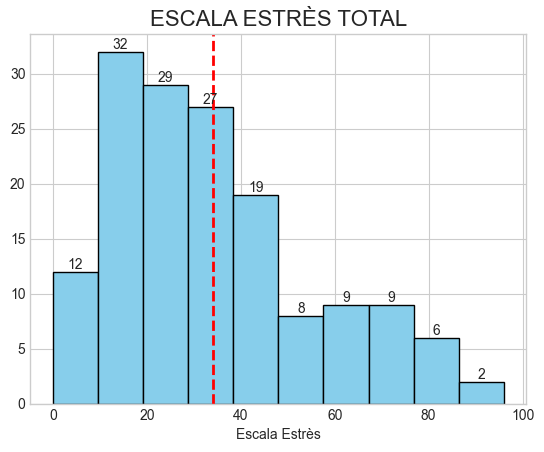

In [27]:
# Calcular la distribución de la columna numérica
distribucion, bins, _ = plt.hist(data_total['INDICE TOTAL'], bins=10, color='skyblue', edgecolor='black')

# Añadir números encima de cada barra
for i, valor in enumerate(distribucion):
    plt.text(bins[i] + (bins[i+1] - bins[i]) / 2, valor, str(int(valor)), ha='center', va='bottom')  # Ajustar la coordenada x

# Calcular la media
media = data_total['INDICE TOTAL'].mean()

# Agregar una línea discontinua en la posición de la media
plt.axvline(x=media, color='red', linestyle='--', linewidth=2, label=f'Media = {media:.2f}')

# Añadir título y etiquetas
plt.title('ESCALA ESTRÈS TOTAL', fontsize=16)
plt.xlabel('Escala Estrès')

# Mostrar el histograma
plt.show()



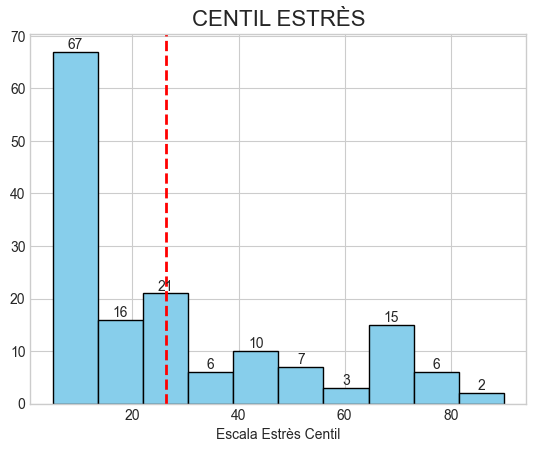

In [28]:
# Calcular la distribución de la columna numérica
distribucion, bins, _ = plt.hist(data_total['CENTIL'], bins=10, color='skyblue', edgecolor='black')

# Añadir números encima de cada barra
for i, valor in enumerate(distribucion):
    plt.text(bins[i] + (bins[i+1] - bins[i]) / 2, valor, str(int(valor)), ha='center', va='bottom')  # Ajustar la coordenada x

# Calcular la media
media = data_total['CENTIL'].mean()

# Agregar una línea discontinua en la posición de la media
plt.axvline(x=media, color='red', linestyle='--', linewidth=2, label=f'Media = {media:.2f}')

# Añadir título y etiquetas
plt.title('CENTIL ESTRÈS', fontsize=16)
plt.xlabel('Escala Estrès Centil')

# Mostrar el histograma
plt.show()

In [29]:
def calcular_descriptivos(datos, columna):
    # Crear DataFrame con las estadísticas descriptivas
    descriptivos_num = pd.DataFrame(data_total[columna]).describe().T

    # Calcular y añadir la asimetría (skewness)
    descriptivos_num["Asimetría"] = data_total[columna].skew()

    # Calcular y añadir la curtosis (kurtosis)
    descriptivos_num["Kurtosis"] = data_total[columna].kurtosis()

    # Calcular y añadir el rango (range)
    descriptivos_num["Rango"] = np.ptp(data_total[columna].dropna().values)

    return descriptivos_num


descriptivos_indice_total = calcular_descriptivos(data_total, 'INDICE TOTAL')
descriptivos_centil = calcular_descriptivos(data_total, 'CENTIL')
descriptivos_unificados = pd.concat([descriptivos_indice_total, descriptivos_centil])
descriptivos_unificados

,count,mean,std,min,25%,50%,75%,max,Asimetría,Kurtosis,Rango
INDICE TOTAL,153.0,34.071895,21.322741,0.0,19.0,29.0,45.0,96.0,0.792586,-0.067118,96
CENTIL,153.0,26.339869,24.047695,5.0,5.0,15.0,40.0,90.0,0.936253,-0.397943,85


In [30]:
#Referenciamos los valores más altos de estrés de la muestra 
#Marcamos corte en desvio de 1 desviación y 2 desviaciones respecto el grupo normativo de referencia.
individuos_1= data_total[data_total['CENTIL']>=55.48]
individuos_2= data_total[data_total['CENTIL']>=76.80]
individuos_3=data_total[data_total['CENTIL']<=34.18]
individuos_4=data_total[data_total['INDICE TOTAL']==0.0]
print('Individuos estrés moderado: 1 desviación típica desviados')
print(len(individuos_1))
print('Individuos estrés alto: 2 desviación típica desviados')
print(len(individuos_2))
print('Individuos estrés por debajo de la media:')
print(len(individuos_3))
print('Individuos estrés 0: respecto INDICE TOTAL')
print(len(individuos_4))

Individuos estrés moderado: 1 desviación típica desviados
26
Individuos estrés alto: 2 desviación típica desviados
2
Individuos estrés por debajo de la media:
104
Individuos estrés 0: respecto INDICE TOTAL
2


## TABLA MEDIA-STD

In [31]:
#FRECUENCIA DEL SI: aquí contabilizamos todos los SI como recuento incluyendo 0.0,sumando A+P
media_Frecuencia_SI=data_total['Frecuencia_SI'].mean()
desv_Frecuencia_SI=data_total['Frecuencia_SI'].std()

#VIGENCIA: aquí contabilizamos todos los SI como recuento incluyendo 0.0 separando en A/P
media_Frecuencia_A=data_total['Frecuencia_SI_A'].mean()
media_Frecuencia_P=data_total['Frecuencia_SI_P'].mean()

#INTENSIDAD: todos estos calculos hacen referencia a intensidad. 
#Por tanto, no se contabilizan los 0.0
media_A=data_total['TOTAL A'].mean()
media_P=data_total['TOTAL P'].mean()
media_TOTAL=data_total['INDICE TOTAL'].mean()
desv_TOTAL=data_total['INDICE TOTAL'].std()

tabla_resultados = pd.DataFrame([['A y P',media_Frecuencia_SI, desv_Frecuencia_SI],
                                 ['A',media_Frecuencia_A,'-'],
                                 ['P',media_Frecuencia_P,'-'],
                                 ['A',media_A,'-'],
                                 ['P',media_P,'-'],
                                 ['TOTAL',media_TOTAL,desv_TOTAL]], columns=['escala','media', 'std'])
tabla_resultados

,escala,media,std
0,A y P,18.169935,8.750031
1,A,10.666667,-
2,P,7.503268,-
3,A,21.888889,-
4,P,12.183007,-
5,TOTAL,34.071895,21.322741


## TABLA DISTRIBUCIÓN MUESTRAL DE LA INTENSIDAD: SI en A/P

In [32]:
def tabla_frecuencia_si(data_total, lista_filas):
    lista_res = []
    for intensidad in lista_filas:
        result = data_total[intensidad].sum()
        lista_res.append(result)
    tabla_SI = pd.DataFrame(list(zip(lista_filas, lista_res)), columns=['Nombres', 'Frecuencia'])
    tabla_SI['Porcentaje'] = tabla_SI['Frecuencia'] / tabla_SI['Frecuencia'].sum() * 100
    return tabla_SI

lista_filas_A = ['A=0.0', 'A=1.0', 'A=2.0', 'A=3.0']
lista_filas_P = ['P=0.0', 'P=1.0', 'P=2.0', 'P=3.0']

tabla_SI_A = tabla_frecuencia_si(data_total, lista_filas_A)
print(tabla_SI_A)
print(f"Total: {tabla_SI_A['Frecuencia'].sum()}")
print('---------------------------------')

tabla_SI_P = tabla_frecuencia_si(data_total, lista_filas_P)
print(tabla_SI_P)
print(f"Total: {tabla_SI_P['Frecuencia'].sum()}")

  Nombres  Frecuencia  Porcentaje
0   A=0.0           7    0.428922
1   A=1.0         462   28.308824
2   A=2.0         602   36.887255
3   A=3.0         561   34.375000
Total: 1632
---------------------------------
  Nombres  Frecuencia  Porcentaje
0   P=0.0         124   10.801394
1   P=1.0         414   36.062718
2   P=2.0         380   33.101045
3   P=3.0         230   20.034843
Total: 1148


## TABLA GÉNERO

In [33]:
lista_edad=['Mujer','Hombre']
lista=['Med','Std','Med','Std']
lista_freq_si=[]
lista_vig_A=[]
lista_vig_P=[]
lista_int_A=[]
lista_int_P=[]
lista_TOTAL=[]

for edad in lista_edad:
    total_med = data_total[data_total['Género'] == edad]['INDICE TOTAL'].mean()
    total_std = data_total[data_total['Género'] == edad]['INDICE TOTAL'].std()
    lista_TOTAL.append(total_med)
    lista_TOTAL.append(total_std)
    freq_si_med=data_total[data_total['Género'] == edad]['Frecuencia_SI'].mean()
    freq_si_std=data_total[data_total['Género'] == edad]['Frecuencia_SI'].std()
    lista_freq_si.append(freq_si_med)
    lista_freq_si.append(freq_si_std)
    vig_A=data_total[data_total['Género'] == edad]['Frecuencia_SI_A'].mean()
    lista_vig_A.append(vig_A)
    lista_vig_A.append('-')
    vig_P=data_total[data_total['Género'] == edad]['Frecuencia_SI_P'].mean()
    lista_vig_P.append(vig_P)
    lista_vig_P.append('-')
    int_A=data_total[data_total['Género'] == edad]['TOTAL A'].mean()
    lista_int_A.append(int_A)
    lista_int_A.append('-')
    int_P=data_total[data_total['Género'] == edad]['TOTAL P'].mean()
    lista_int_P.append(int_P)
    lista_int_P.append('-')
    
df = pd.DataFrame([lista, lista_freq_si,lista_vig_A,lista_vig_P,lista_int_A,lista_int_P,lista_TOTAL])
df.reset_index(drop=True, inplace=True)
df  

,0,1,2,3
0,Med,Std,Med,Std
1,18.920792,8.970711,16.711538,8.192145
2,11.564356,-,8.923077,-
3,7.356436,-,7.788462,-
4,24.287129,-,17.230769,-
5,11.732673,-,13.057692,-
6,36.019802,21.866404,30.288462,19.885295


## TABLA EDAD

In [34]:
lista_edad=['18 - 25','26 - 35','36 - 45','46 - 55','56 - 64']
lista=['Med','Std','Med','Std','Med','Std','Med','Std','Med','Std']
lista_freq_si=[]
lista_vig_A=[]
lista_vig_P=[]
lista_int_A=[]
lista_int_P=[]
lista_TOTAL=[]
lista_columnas=['18 - 25','18 - 25','26 - 35','26 - 35','36 - 45','36 - 45','46 - 55','46 - 55','56 - 64','56 - 64']

for edad in lista_edad:
    total_med = data_total[data_total['Edad'] == edad]['INDICE TOTAL'].mean()
    total_std = data_total[data_total['Edad'] == edad]['INDICE TOTAL'].std()
    lista_TOTAL.append(total_med)
    lista_TOTAL.append(total_std)
    freq_si_med=data_total[data_total['Edad'] == edad]['Frecuencia_SI'].mean()
    freq_si_std=data_total[data_total['Edad'] == edad]['Frecuencia_SI'].std()
    lista_freq_si.append(freq_si_med)
    lista_freq_si.append(freq_si_std)
    vig_A=data_total[data_total['Edad'] == edad]['Frecuencia_SI_A'].mean()
    lista_vig_A.append(vig_A)
    lista_vig_A.append('-')
    vig_P=data_total[data_total['Edad'] == edad]['Frecuencia_SI_P'].mean()
    lista_vig_P.append(vig_P)
    lista_vig_P.append('-')
    int_A=data_total[data_total['Edad'] == edad]['TOTAL A'].mean()
    lista_int_A.append(int_A)
    lista_int_A.append('-')
    int_P=data_total[data_total['Edad'] == edad]['TOTAL P'].mean()
    lista_int_P.append(int_P)
    lista_int_P.append('-')
    
df = pd.DataFrame([ lista_columnas,lista, lista_freq_si,lista_vig_A,lista_vig_P,lista_int_A,lista_int_P,lista_TOTAL])
df.reset_index(drop=True, inplace=True)
df

,0,1,2,3,4,5,6,7,8,9
0,18 - 25,18 - 25,26 - 35,26 - 35,36 - 45,36 - 45,46 - 55,46 - 55,56 - 64,56 - 64
1,Med,Std,Med,Std,Med,Std,Med,Std,Med,Std
2,15.569892,7.047044,22.6,7.933053,21.4375,7.780049,22.0625,10.560737,22.777778,11.634409
3,9.451613,-,13.1,-,12.25,-,12.3125,-,12.722222,-
4,6.11828,-,9.5,-,9.1875,-,9.75,-,10.055556,-
5,18.741935,-,27.9,-,24.6875,-,27.5625,-,27.277778,-
6,8.688172,-,16.7,-,15.9375,-,18.0,-,19.222222,-
7,27.430108,16.246336,44.6,19.895281,40.625,20.5,45.5625,27.224912,46.5,27.706975


## TABLA OCUPACIÓN ACTUAL

In [35]:
lista_edad=['Estudiante','Empleado','Estudiante + trabajador','Desempleado']
lista_freq_si=[]
lista_vig_A=[]
lista_vig_P=[]
lista_int_A=[]
lista_int_P=[]
lista_TOTAL=[]

for edad in lista_edad:
    total_med = data_total[data_total['Ocupación actual'] == edad]['INDICE TOTAL'].mean()
    total_std = data_total[data_total['Ocupación actual'] == edad]['INDICE TOTAL'].std()
    lista_TOTAL.append(total_med)
    lista_TOTAL.append(total_std)
    freq_si_med=data_total[data_total['Ocupación actual'] == edad]['Frecuencia_SI'].mean()
    freq_si_std=data_total[data_total['Ocupación actual'] == edad]['Frecuencia_SI'].std()
    lista_freq_si.append(freq_si_med)
    lista_freq_si.append(freq_si_std)
    vig_A=data_total[data_total['Ocupación actual'] == edad]['Frecuencia_SI_A'].mean()
    lista_vig_A.append(vig_A)
    lista_vig_A.append('-')
    vig_P=data_total[data_total['Ocupación actual'] == edad]['Frecuencia_SI_P'].mean()
    lista_vig_P.append(vig_P)
    lista_vig_P.append('-')
    int_A=data_total[data_total['Ocupación actual'] == edad]['TOTAL A'].mean()
    lista_int_A.append(int_A)
    lista_int_A.append('-')
    int_P=data_total[data_total['Ocupación actual'] == edad]['TOTAL P'].mean()
    lista_int_P.append(int_P)
    lista_int_P.append('-')
    
df = pd.DataFrame([lista_freq_si,lista_vig_A,lista_vig_P,lista_int_A,lista_int_P,lista_TOTAL])
df.reset_index(drop=True, inplace=True)
df  

,0,1,2,3,4,5,6,7
0,15.113208,6.787036,21.400,10.845772,18.023256,7.857324,20.470588,8.132632
1,8.528302,-,12.425,-,11.418605,-,11.294118,-
2,6.584906,-,8.975,-,6.604651,-,9.176471,-
3,16.905660,-,25.700,-,23.139535,-,25.294118,-
4,8.867925,-,15.225,-,11.279070,-,17.647059,-
5,25.773585,14.943022,40.925,25.443137,34.418605,20.710283,42.941176,21.454809


## TABLA CARGO PROFESIONAL MODIFICADO

In [36]:
lista_edad=['Empleado','Responsable','Autónomo']
lista_freq_si=[]
lista_vig_A=[]
lista_vig_P=[]
lista_int_A=[]
lista_int_P=[]
lista_TOTAL=[]

for edad in lista_edad:
    total_med = data_total[data_total['Cargo que desarrolla en el trabajo 2'] == edad]['INDICE TOTAL'].mean()
    total_std = data_total[data_total['Cargo que desarrolla en el trabajo 2'] == edad]['INDICE TOTAL'].std()
    lista_TOTAL.append(total_med)
    lista_TOTAL.append(total_std)
    freq_si_med=data_total[data_total['Cargo que desarrolla en el trabajo 2'] == edad]['Frecuencia_SI'].mean()
    freq_si_std=data_total[data_total['Cargo que desarrolla en el trabajo 2'] == edad]['Frecuencia_SI'].std()
    lista_freq_si.append(freq_si_med)
    lista_freq_si.append(freq_si_std)
    vig_A=data_total[data_total['Cargo que desarrolla en el trabajo 2'] == edad]['Frecuencia_SI_A'].mean()
    lista_vig_A.append(vig_A)
    lista_vig_A.append('-')
    vig_P=data_total[data_total['Cargo que desarrolla en el trabajo 2'] == edad]['Frecuencia_SI_P'].mean()
    lista_vig_P.append(vig_P)
    lista_vig_P.append('-') 
    int_A=data_total[data_total['Cargo que desarrolla en el trabajo 2'] == edad]['TOTAL A'].mean()
    lista_int_A.append(int_A)
    lista_int_A.append('-')
    int_P=data_total[data_total['Cargo que desarrolla en el trabajo 2'] == edad]['TOTAL P'].mean()
    lista_int_P.append(int_P)
    lista_int_P.append('-')
    
df = pd.DataFrame([lista_freq_si,lista_vig_A,lista_vig_P,lista_int_A,lista_int_P,lista_TOTAL])
df.reset_index(drop=True, inplace=True)
df  

,0,1,2,3,4,5
0,19.360656,9.332797,20.894737,10.702517,17.666667,6.429101
1,11.377049,-,13.421053,-,13.000000,-
2,7.983607,-,7.473684,-,4.666667,-
3,23.508197,-,28.052632,-,18.666667,-
4,13.426230,-,13.473684,-,6.333333,-
5,36.934426,23.175324,41.526316,24.626924,25.000000,10.0


## TABLA NIVEL ESTUDIOS MODIFICADO

In [37]:
lista_edad=['Obligatoria','Intermedia','Superior',]
lista_freq_si=[]
lista_vig_A=[]
lista_vig_P=[]
lista_int_A=[]
lista_int_P=[]
lista_TOTAL=[]

for edad in lista_edad:
    total_med = data_total[data_total['Nivel de estudios logrados 2'] == edad]['INDICE TOTAL'].mean()
    total_std = data_total[data_total['Nivel de estudios logrados 2'] == edad]['INDICE TOTAL'].std()
    lista_TOTAL.append(total_med)
    lista_TOTAL.append(total_std)
    freq_si_med=data_total[data_total['Nivel de estudios logrados 2'] == edad]['Frecuencia_SI'].mean()
    freq_si_std=data_total[data_total['Nivel de estudios logrados 2'] == edad]['Frecuencia_SI'].std()
    lista_freq_si.append(freq_si_med)
    lista_freq_si.append(freq_si_std)
    vig_A=data_total[data_total['Nivel de estudios logrados 2'] == edad]['Frecuencia_SI_A'].mean()
    lista_vig_A.append(vig_A)
    lista_vig_A.append('-')
    vig_P=data_total[data_total['Nivel de estudios logrados 2'] == edad]['Frecuencia_SI_P'].mean()
    lista_vig_P.append(vig_P)
    lista_vig_P.append('-')
    int_A=data_total[data_total['Nivel de estudios logrados 2'] == edad]['TOTAL A'].mean()
    lista_int_A.append(int_A)
    lista_int_A.append('-')
    int_P=data_total[data_total['Nivel de estudios logrados 2'] == edad]['TOTAL P'].mean()
    lista_int_P.append(int_P)
    lista_int_P.append('-')
    
df = pd.DataFrame([lista_freq_si,lista_vig_A,lista_vig_P,lista_int_A,lista_int_P,lista_TOTAL])
df.reset_index(drop=True, inplace=True)
df  

,0,1,2,3,4,5
0,21.045455,8.323674,18.046512,8.190248,17.000000,9.811867
1,12.318182,-,10.755814,-,9.688889,-
2,8.727273,-,7.290698,-,7.311111,-
3,27.136364,-,22.139535,-,18.844444,-
4,17.636364,-,11.197674,-,11.400000,-
5,44.772727,22.815892,33.337209,20.878703,30.244444,20.168783


## DISTRIBUCIÓN OPERAS

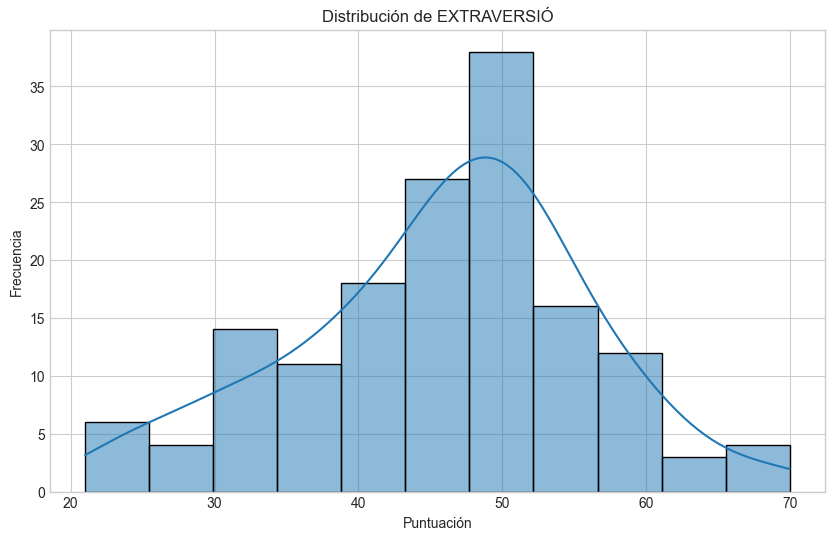

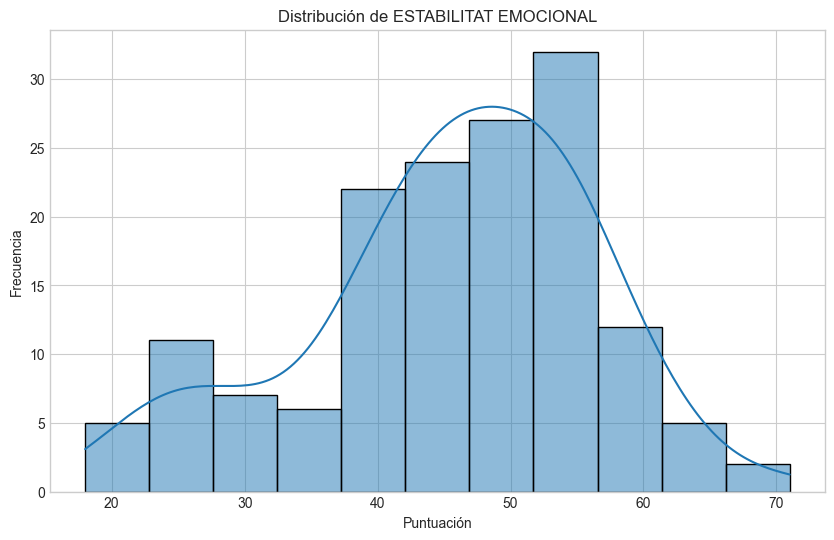

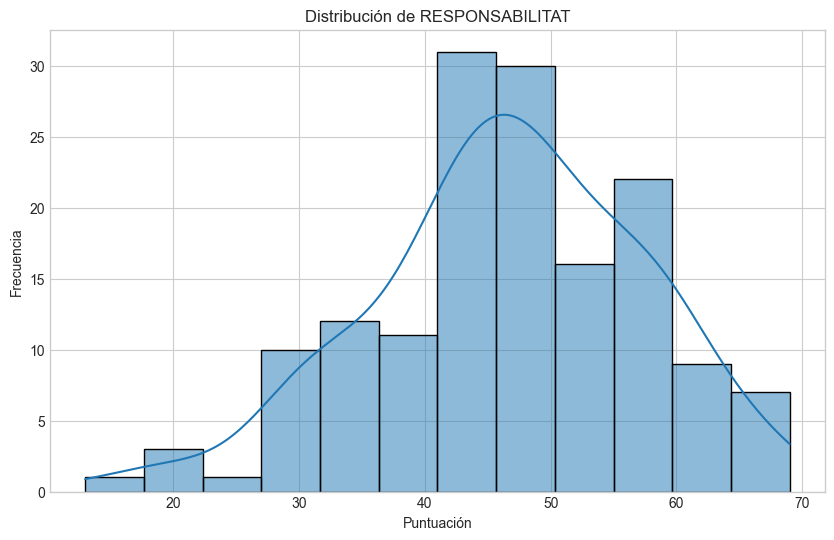

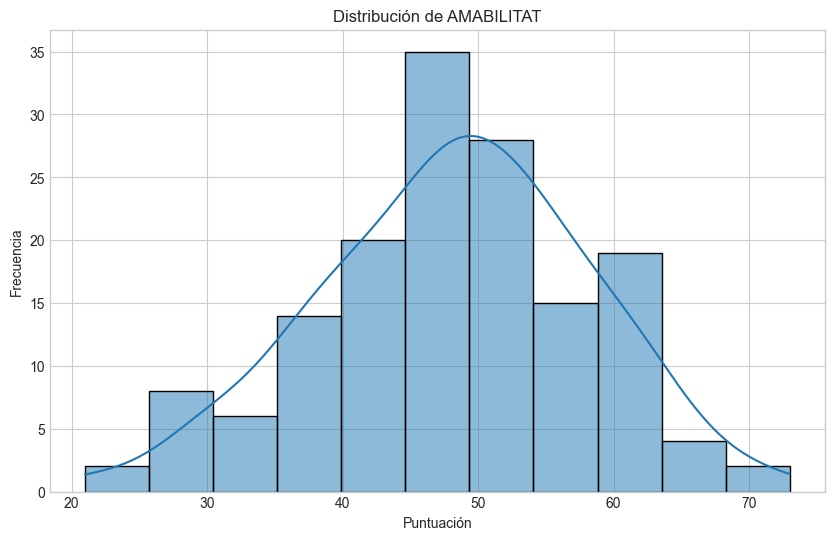

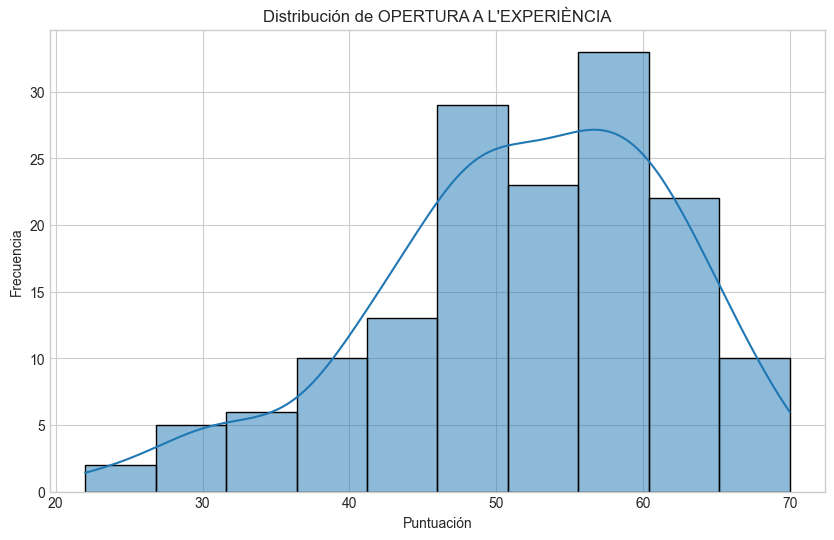

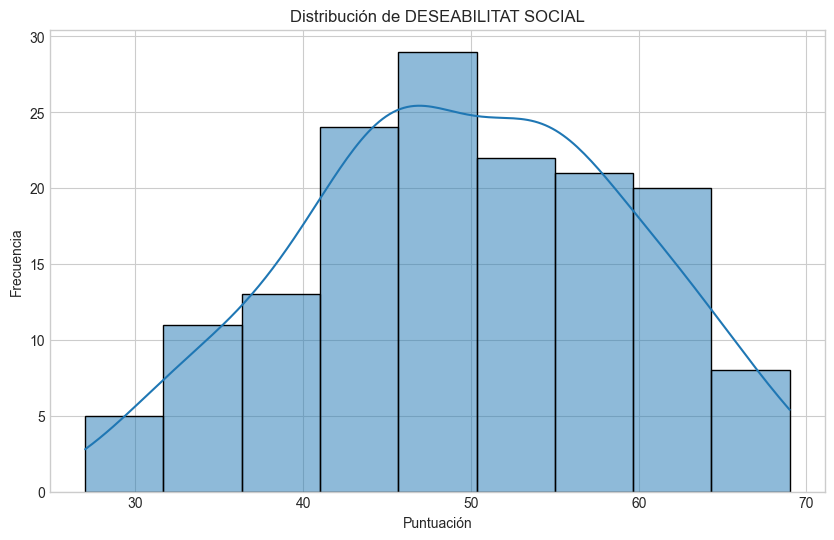

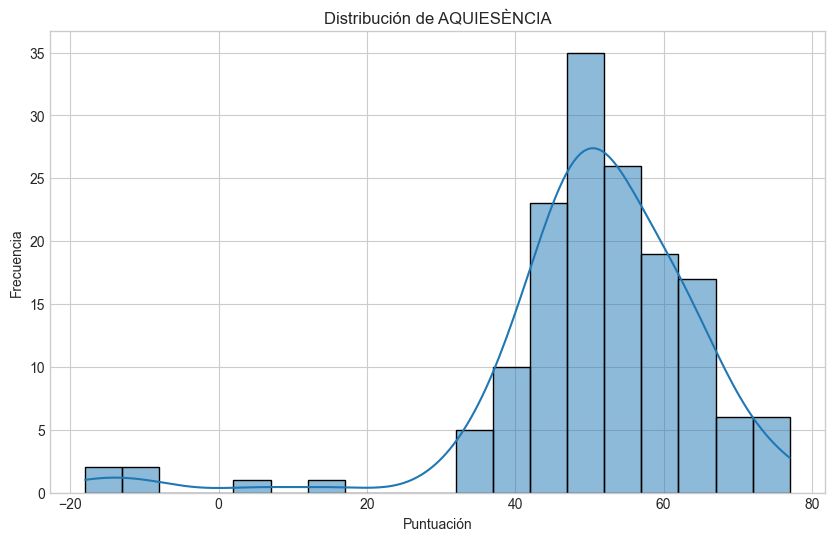

In [38]:
nombres_col=['EXTRAVERSIÓ','ESTABILITAT EMOCIONAL','RESPONSABILITAT','AMABILITAT',"OPERTURA A L'EXPERIÈNCIA",'DESEABILITAT SOCIAL','AQUIESÈNCIA']

for col in nombres_col:
    plt.figure(figsize=(10, 6))
    sns.histplot(data_total[col], kde=True)
    plt.title(f'Distribución de {col}')
    plt.xlabel('Puntuación')
    plt.ylabel('Frecuencia')
    plt.show()

# CORRELACIÓN DE PEARSON

In [39]:
# Identificar las filas que cumplen con la condición
individuos_eliminar = data_total[data_total['AQUIESÈNCIA'] <= 15]

# Eliminar estas filas del DataFrame
data_total = data_total.drop(individuos_eliminar.index)

# Reiniciar los índices del DataFrame
data_total.reset_index(drop=True, inplace=True)

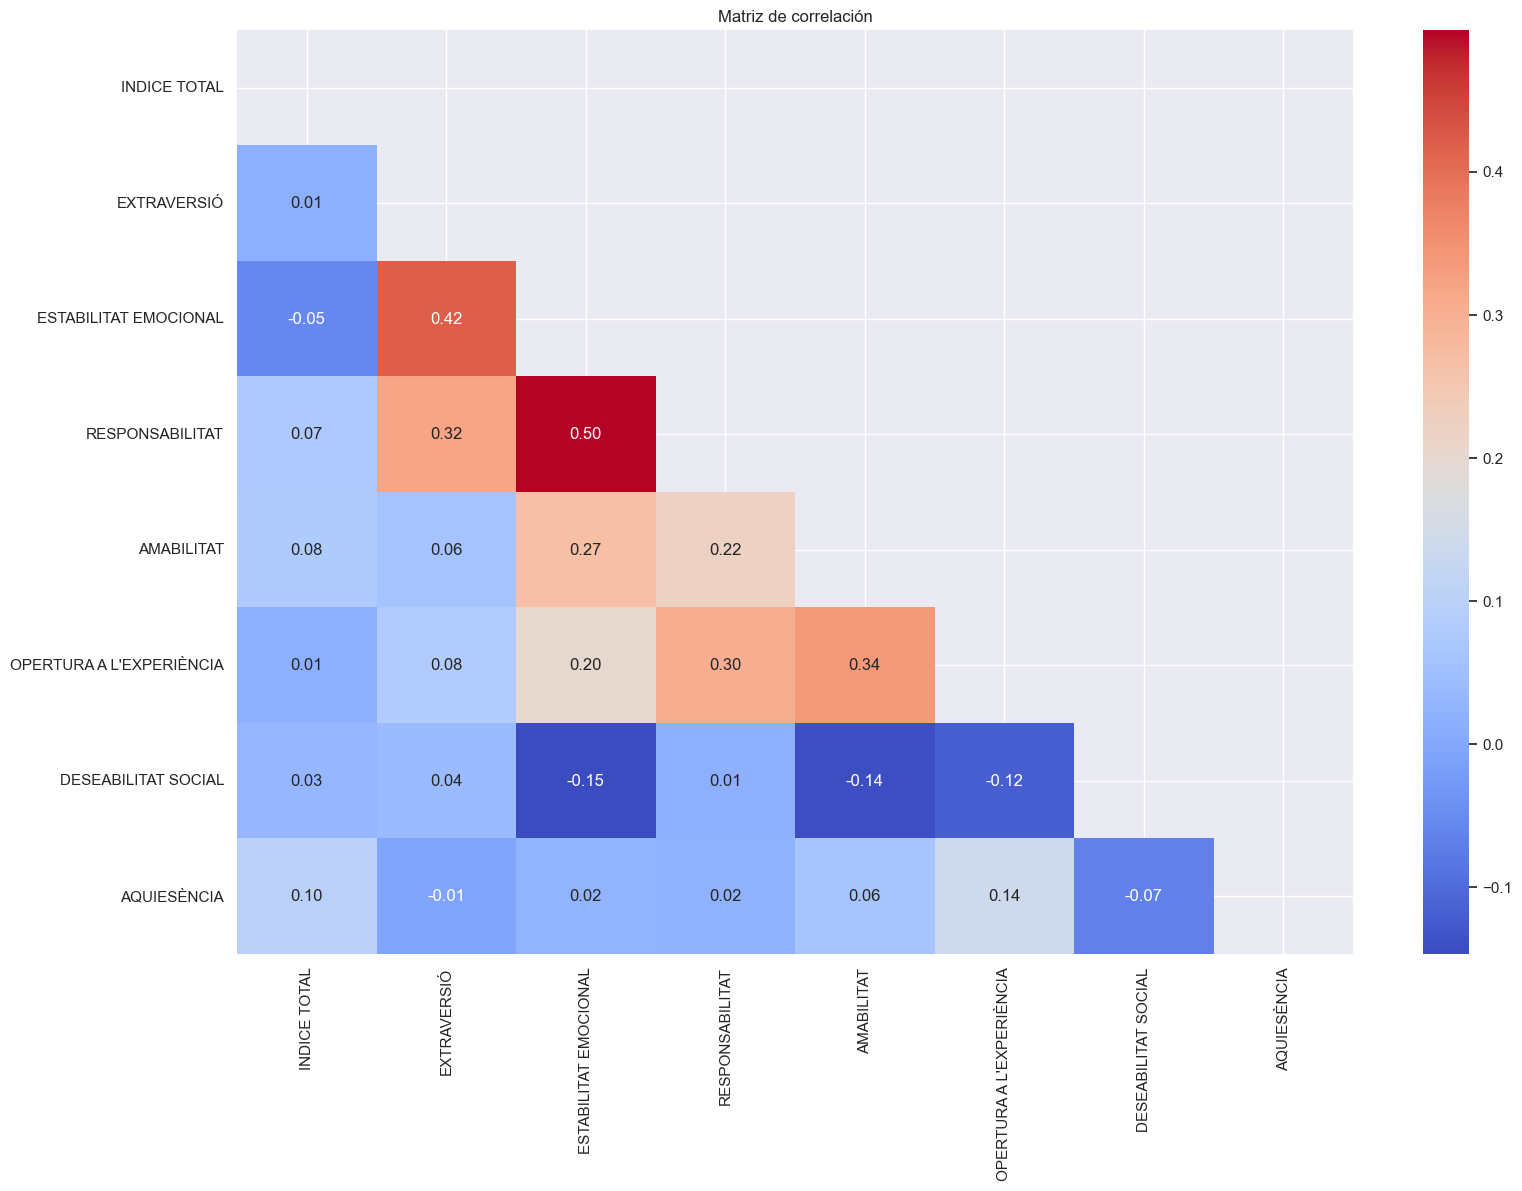

In [40]:
varObj=data_total['INDICE TOTAL']
datos_entrada=data_total[['EXTRAVERSIÓ','ESTABILITAT EMOCIONAL','RESPONSABILITAT','AMABILITAT',"OPERTURA A L'EXPERIÈNCIA",'DESEABILITAT SOCIAL','AQUIESÈNCIA']]

matriz_corr = pd.concat([varObj, datos_entrada], axis = 1).corr(method = 'pearson')
# Crear una máscara para ocultar la mitad superior de la matriz de correlación (triangular superior)
mask = np.triu(np.ones_like(matriz_corr, dtype=bool))
# Crear una figura para el gráfico con un tamaño de 8x6 pulgadas
plt.figure(figsize=(18, 12))
# Establecer el tamaño de fuente en el gráfico
sns.set(font_scale=1.0)
# Crear un mapa de calor (heatmap) de la matriz de correlación
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, mask=mask)
# Establecer el título del gráfico
plt.title("Matriz de correlación")
# Mostrar el gráfico de la matriz de correlación
plt.show()

## CORRELACIÓN POR GÉNERO

In [41]:
centil_mujeres = data_total.loc[data_total['Género'] == 'Mujer','INDICE TOTAL']
ex_mujeres = data_total.loc[data_total['Género'] == 'Mujer','EXTRAVERSIÓ']
ee_mujeres = data_total.loc[data_total['Género'] == 'Mujer','ESTABILITAT EMOCIONAL']
re_mujeres = data_total.loc[data_total['Género'] == 'Mujer','RESPONSABILITAT']
am_mujeres=data_total.loc[data_total['Género'] == 'Mujer','AMABILITAT']
oe_mujeres = data_total.loc[data_total['Género'] == 'Mujer',"OPERTURA A L'EXPERIÈNCIA"]
ds_mujeres = data_total.loc[data_total['Género'] == 'Mujer','DESEABILITAT SOCIAL']
aq_mujeres = data_total.loc[data_total['Género'] == 'Mujer','AQUIESÈNCIA']

data_mujeres = pd.DataFrame().assign(
    INDICETOTAL=centil_mujeres,
    EXTRAVERSIÓ_=ex_mujeres,
    ESTABILITAT_EMOCIONAL_=ee_mujeres,
    RESPONSABILITAT_=re_mujeres,
    AMABILITAT=am_mujeres,
    OPERTURA_A_L_EXPERIÈNCIA_=oe_mujeres,
    DESEABILITAT_SOCIAL_=ds_mujeres,
    AQUIESÈNCIA_=aq_mujeres
)

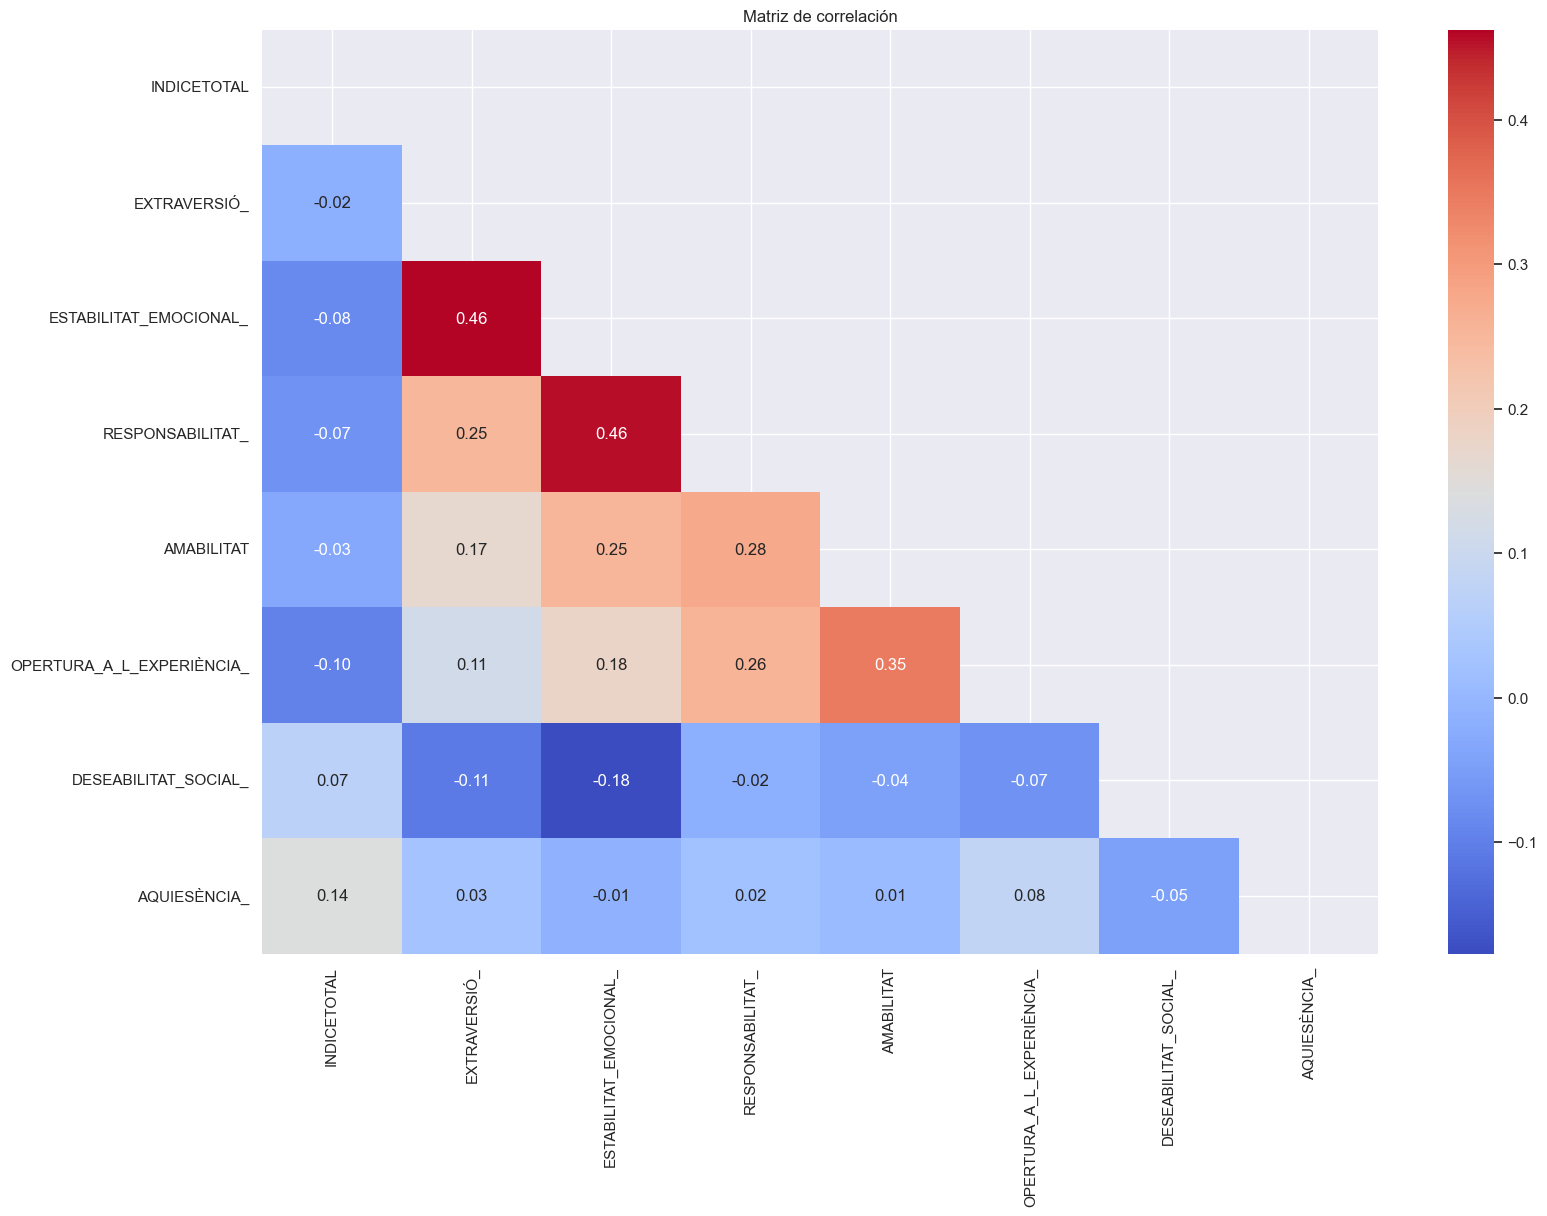

In [42]:
varObj=data_mujeres['INDICETOTAL']
datos_entrada=data_mujeres[['EXTRAVERSIÓ_','ESTABILITAT_EMOCIONAL_','RESPONSABILITAT_','AMABILITAT','OPERTURA_A_L_EXPERIÈNCIA_','DESEABILITAT_SOCIAL_','AQUIESÈNCIA_']]


matriz_corr = pd.concat([varObj, datos_entrada], axis = 1).corr(method = 'pearson')
# Crear una máscara para ocultar la mitad superior de la matriz de correlación (triangular superior)
mask = np.triu(np.ones_like(matriz_corr, dtype=bool))
# Crear una figura para el gráfico con un tamaño de 8x6 pulgadas
plt.figure(figsize=(18, 12))
# Establecer el tamaño de fuente en el gráfico
sns.set(font_scale=1.0)
# Crear un mapa de calor (heatmap) de la matriz de correlación
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, mask=mask)
# Establecer el título del gráfico
plt.title("Matriz de correlación")
# Mostrar el gráfico de la matriz de correlación
plt.show()

In [43]:
centil_hombre = data_total.loc[data_total['Género'] == 'Hombre','INDICE TOTAL']
ex_hombre = data_total.loc[data_total['Género'] == 'Hombre','EXTRAVERSIÓ']
ee_hombre = data_total.loc[data_total['Género'] == 'Hombre','ESTABILITAT EMOCIONAL']
re_hombre = data_total.loc[data_total['Género'] == 'Hombre','RESPONSABILITAT']
am_hombre=data_total.loc[data_total['Género'] == 'Hombre','AMABILITAT']
oe_hombre = data_total.loc[data_total['Género'] == 'Hombre',"OPERTURA A L'EXPERIÈNCIA"]
ds_hombre = data_total.loc[data_total['Género'] == 'Hombre','DESEABILITAT SOCIAL']
aq_hombre = data_total.loc[data_total['Género'] == 'Hombre','AQUIESÈNCIA']

data_hombre = pd.DataFrame().assign(
    INDICETOTAL=centil_hombre,
    EXTRAVERSIÓ_=ex_hombre,
    ESTABILITAT_EMOCIONAL_=ee_hombre,
    RESPONSABILITAT_=re_hombre,
    AMABILITAT=am_hombre,
    OPERTURA_A_L_EXPERIÈNCIA_=oe_hombre,
    DESEABILITAT_SOCIAL_=ds_hombre,
    AQUIESÈNCIA_=aq_hombre
)

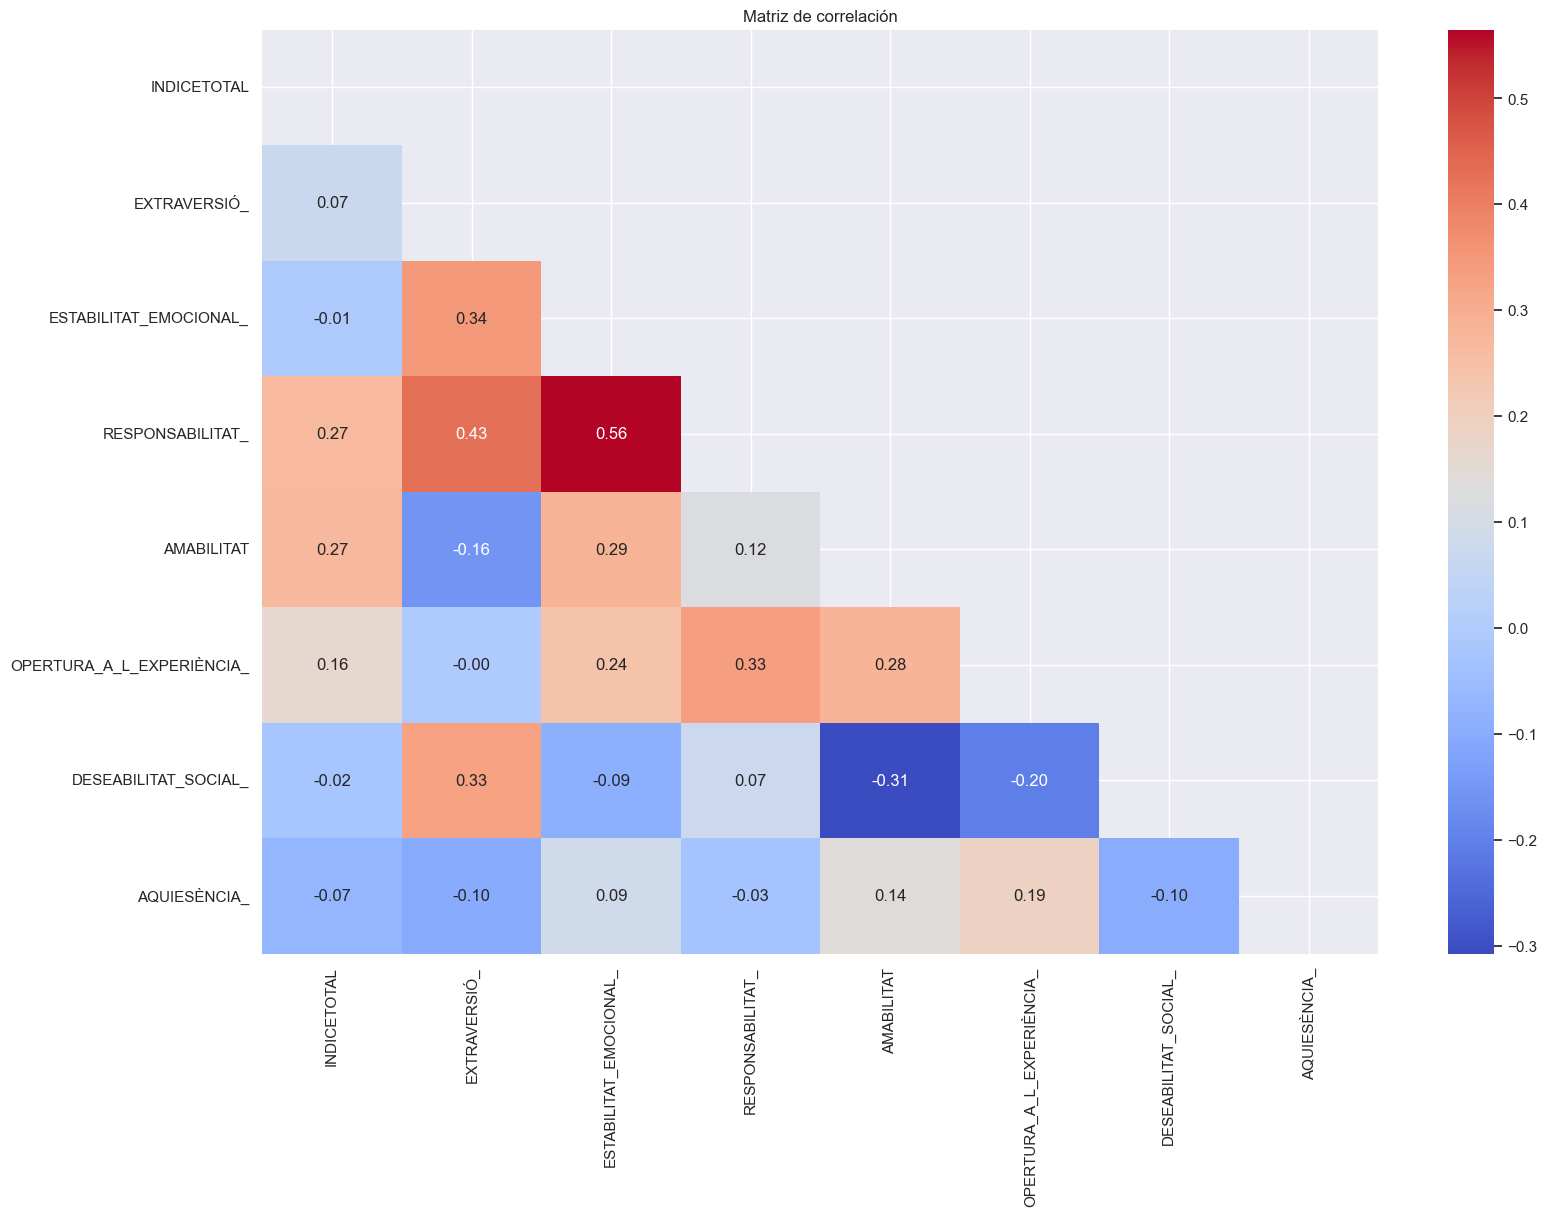

In [44]:
varObj=data_hombre['INDICETOTAL']
datos_entrada=data_hombre[['EXTRAVERSIÓ_','ESTABILITAT_EMOCIONAL_','RESPONSABILITAT_','AMABILITAT',"OPERTURA_A_L_EXPERIÈNCIA_",'DESEABILITAT_SOCIAL_','AQUIESÈNCIA_']]


matriz_corr = pd.concat([varObj, datos_entrada], axis = 1).corr(method = 'pearson')
# Crear una máscara para ocultar la mitad superior de la matriz de correlación (triangular superior)
mask = np.triu(np.ones_like(matriz_corr, dtype=bool))
# Crear una figura para el gráfico con un tamaño de 8x6 pulgadas
plt.figure(figsize=(18, 12))
# Establecer el tamaño de fuente en el gráfico
sns.set(font_scale=1.0)
# Crear un mapa de calor (heatmap) de la matriz de correlación
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, mask=mask)
# Establecer el título del gráfico
plt.title("Matriz de correlación")
# Mostrar el gráfico de la matriz de correlación
plt.show()

## CORRELACIÓN POR EDAD

In [45]:
def generar_dataframe_edad(data_total, edad):
    # Filtrar el DataFrame por la franja de edad
    data_edad = data_total[data_total['Edad'] == edad]

    # Obtener las columnas específicas para esta franja de edad
    centil_edad = data_edad['INDICE TOTAL']
    ex_edad = data_edad['EXTRAVERSIÓ']
    ee_edad = data_edad['ESTABILITAT EMOCIONAL']
    re_edad = data_edad['RESPONSABILITAT']
    am_edad = data_edad['AMABILITAT']
    oe_edad = data_edad["OPERTURA A L'EXPERIÈNCIA"]
    ds_edad = data_edad['DESEABILITAT SOCIAL']
    aq_edad = data_edad['AQUIESÈNCIA']

    # Crear el DataFrame para esta franja de edad
    data_edad_df = pd.DataFrame({
        'INDICETOTAL': centil_edad,
        'EXTRAVERSIÓ_': ex_edad,
        'ESTABILITAT_EMOCIONAL_': ee_edad,
        'RESPONSABILITAT_': re_edad,
        'AMABILITAT': am_edad,
        'OPERTURA_A_L_EXPERIÈNCIA_': oe_edad,
        'DESEABILITAT_SOCIAL_': ds_edad,
        'AQUIESÈNCIA_': aq_edad
    })

    return data_edad_df

dataframes_por_edad = {}

lista_edad=['18 - 25','26 - 35','36 - 45','46 - 55','56 - 64']

for edad in lista_edad:
    # Generar el DataFrame para esta franja de edad y almacenarlo en el diccionario
    dataframes_por_edad[edad] = generar_dataframe_edad(data_total, edad)

In [46]:
def visualizar_matriz_correlacion(varObj, datos_entrada):
    # Calcular la matriz de correlación
    matriz_corr = pd.concat([varObj, datos_entrada], axis=1).corr(method='pearson')
    
    # Crear una máscara para ocultar la mitad superior de la matriz de correlación (triangular superior)
    mask = np.triu(np.ones_like(matriz_corr, dtype=bool))
    
    # Crear una figura para el gráfico con un tamaño de 18x12 pulgadas
    plt.figure(figsize=(18, 12))
    
    # Establecer el tamaño de fuente en el gráfico
    sns.set(font_scale=1.0)
    
    # Crear un mapa de calor (heatmap) de la matriz de correlación
    sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, mask=mask)
    
    # Establecer el título del gráfico
    plt.title("Matriz de correlación")
    
    # Mostrar el gráfico de la matriz de correlación
    plt.show()

18 - 25, individuos:88


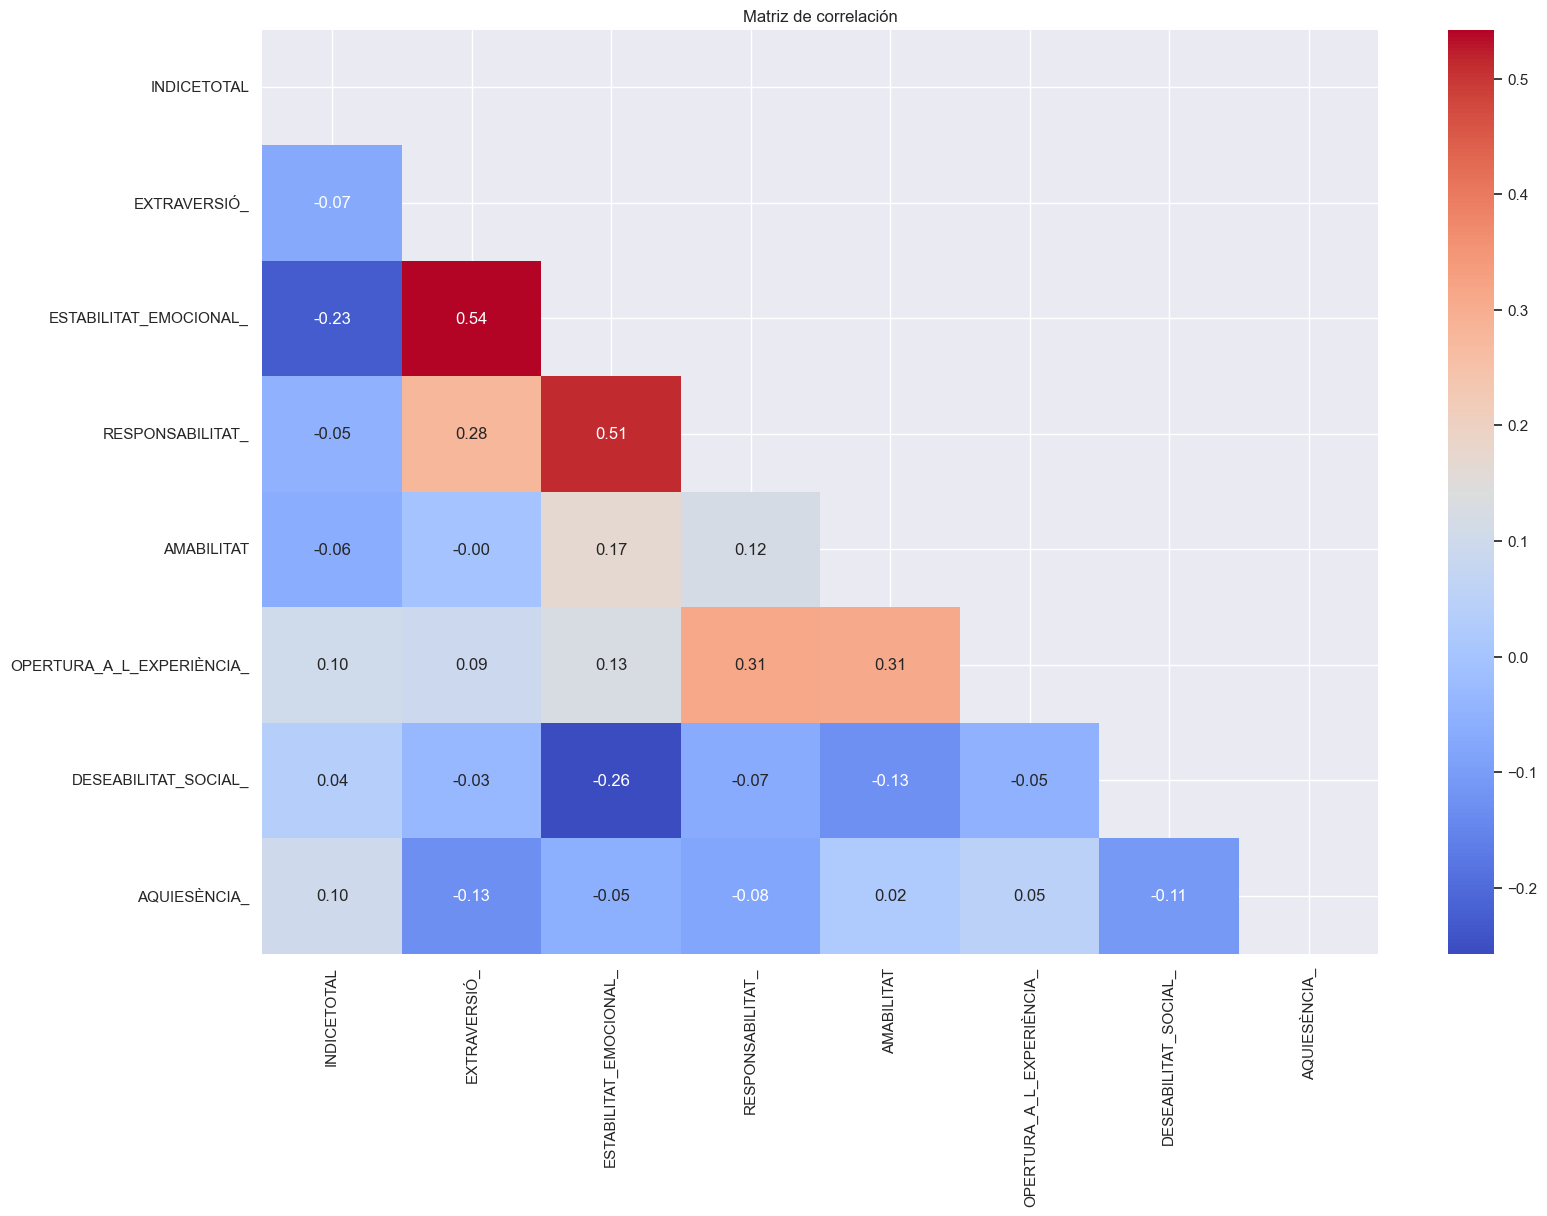

26 - 35, individuos:10


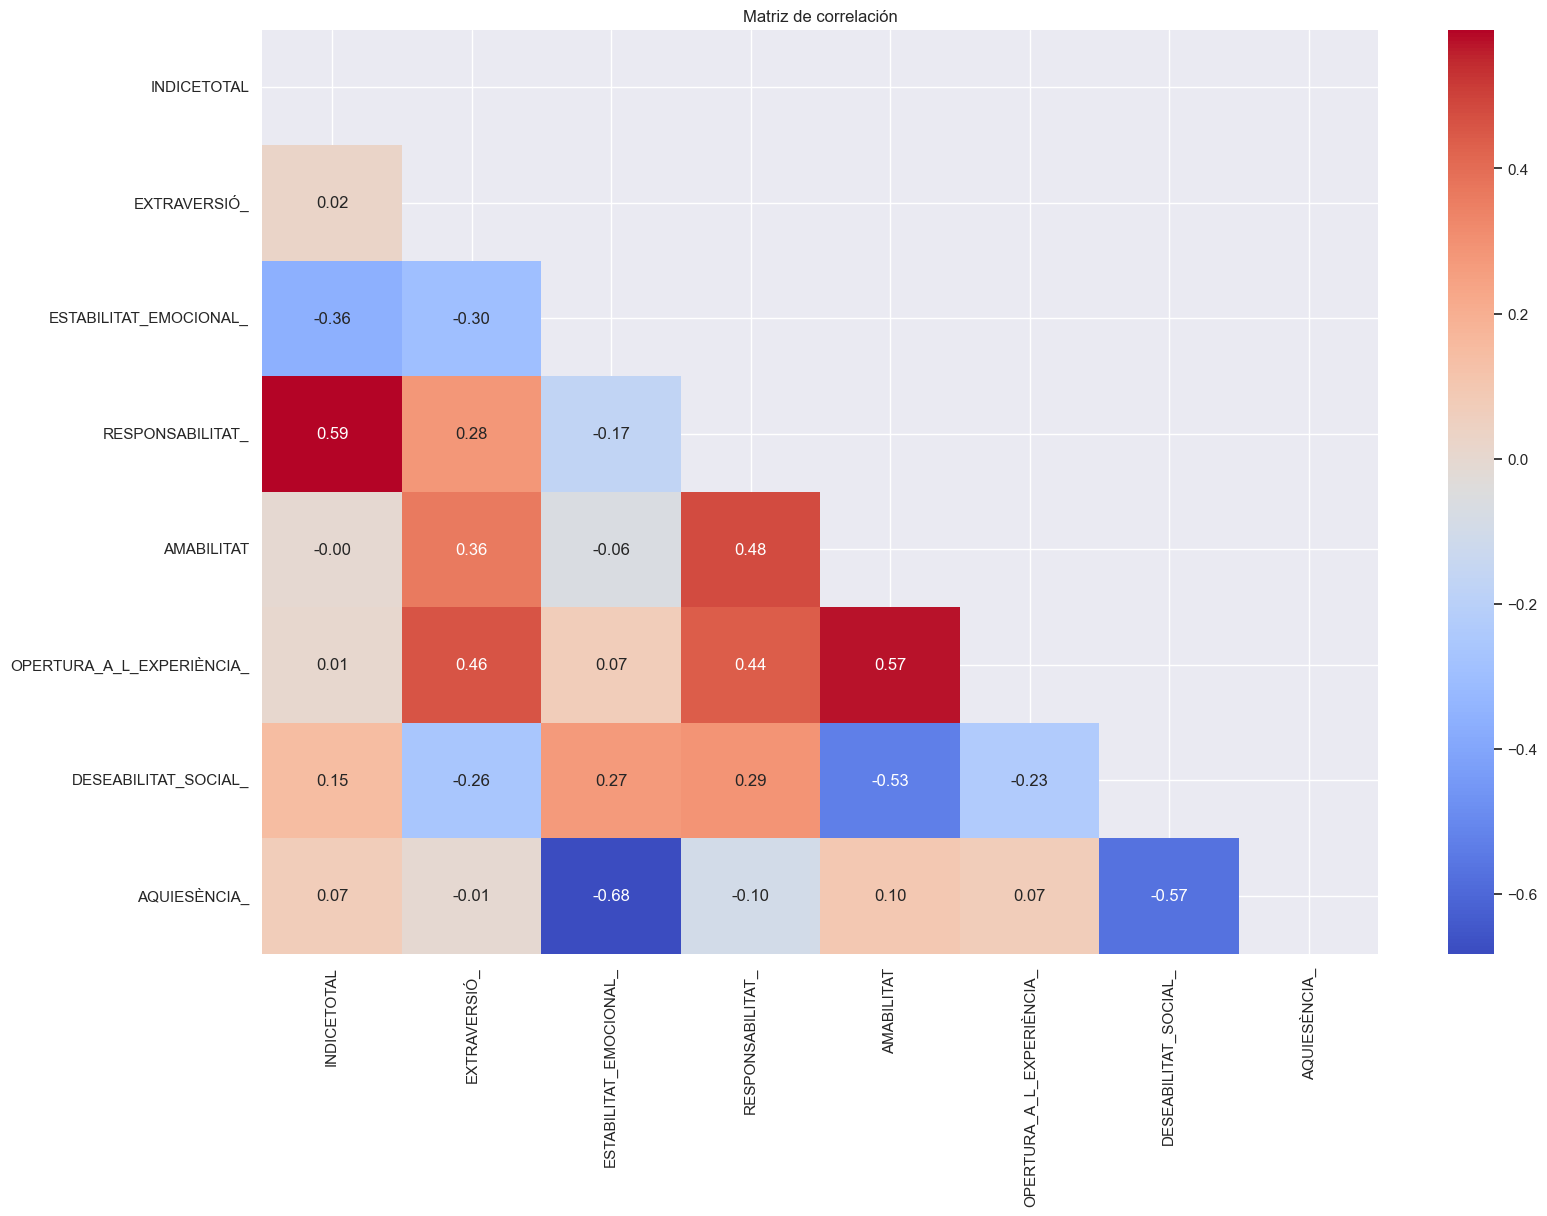

36 - 45, individuos:16


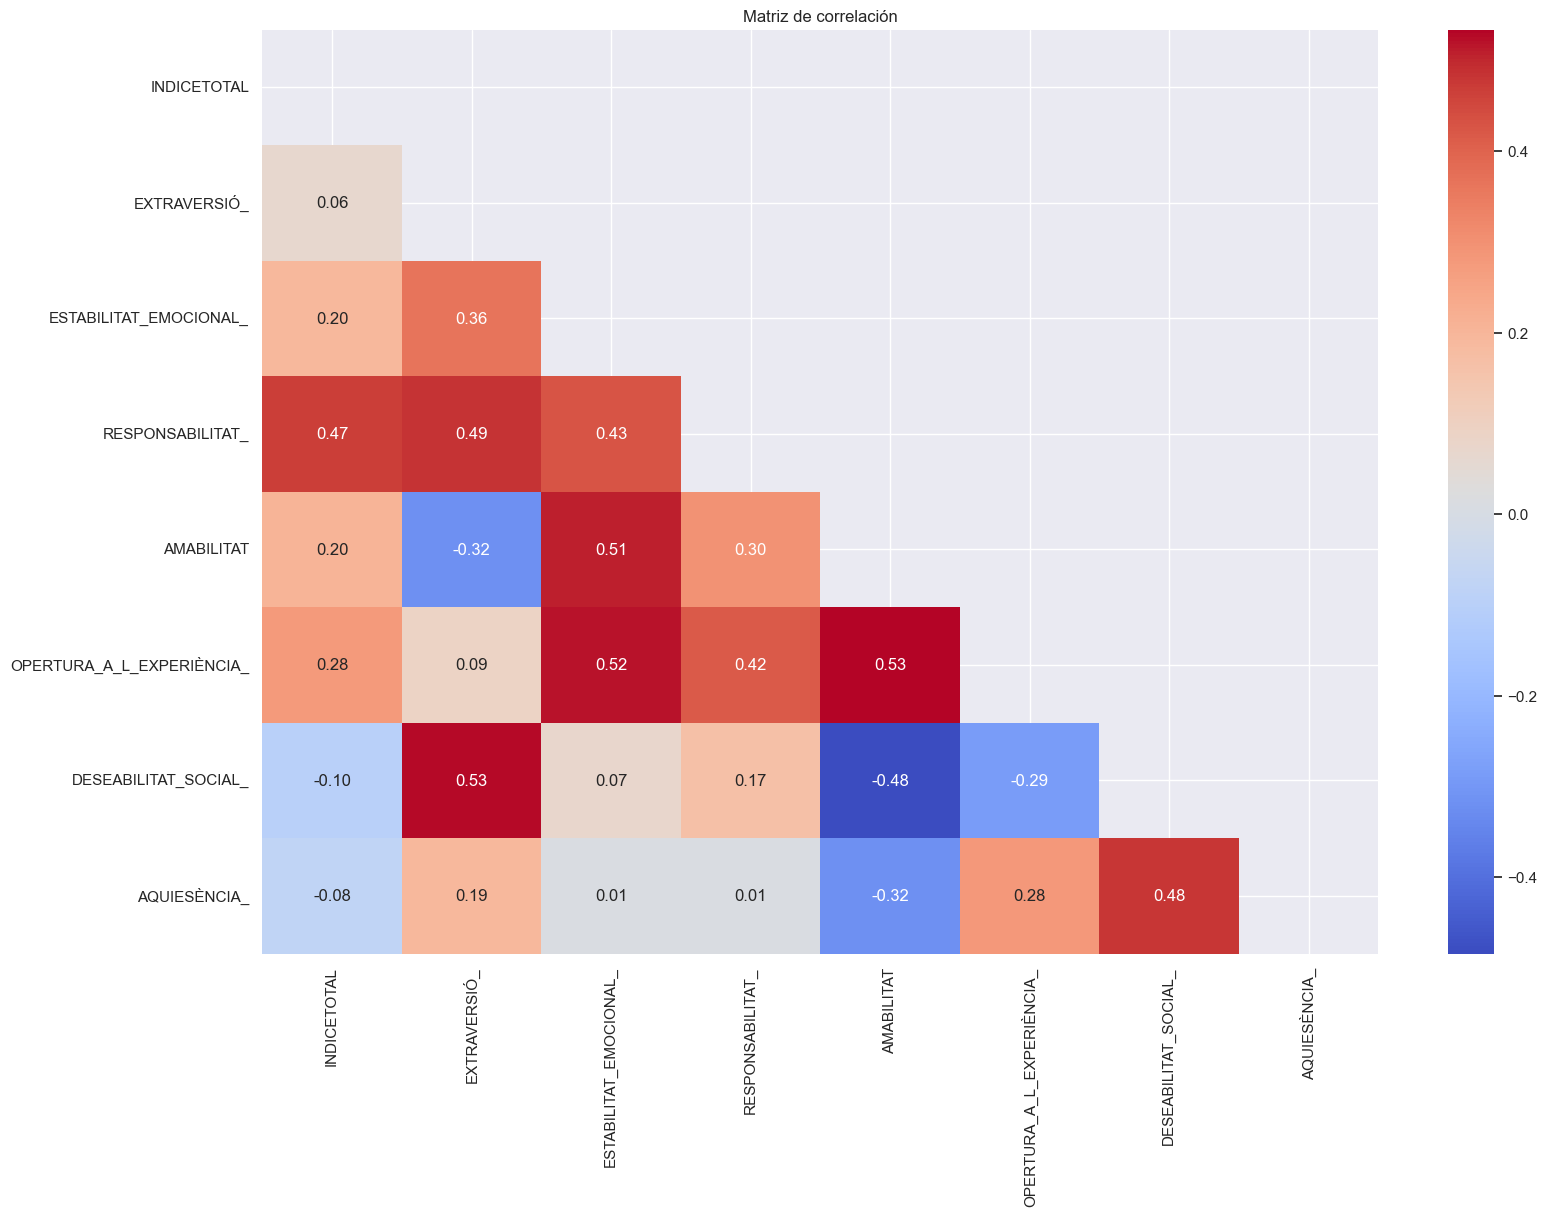

46 - 55, individuos:16


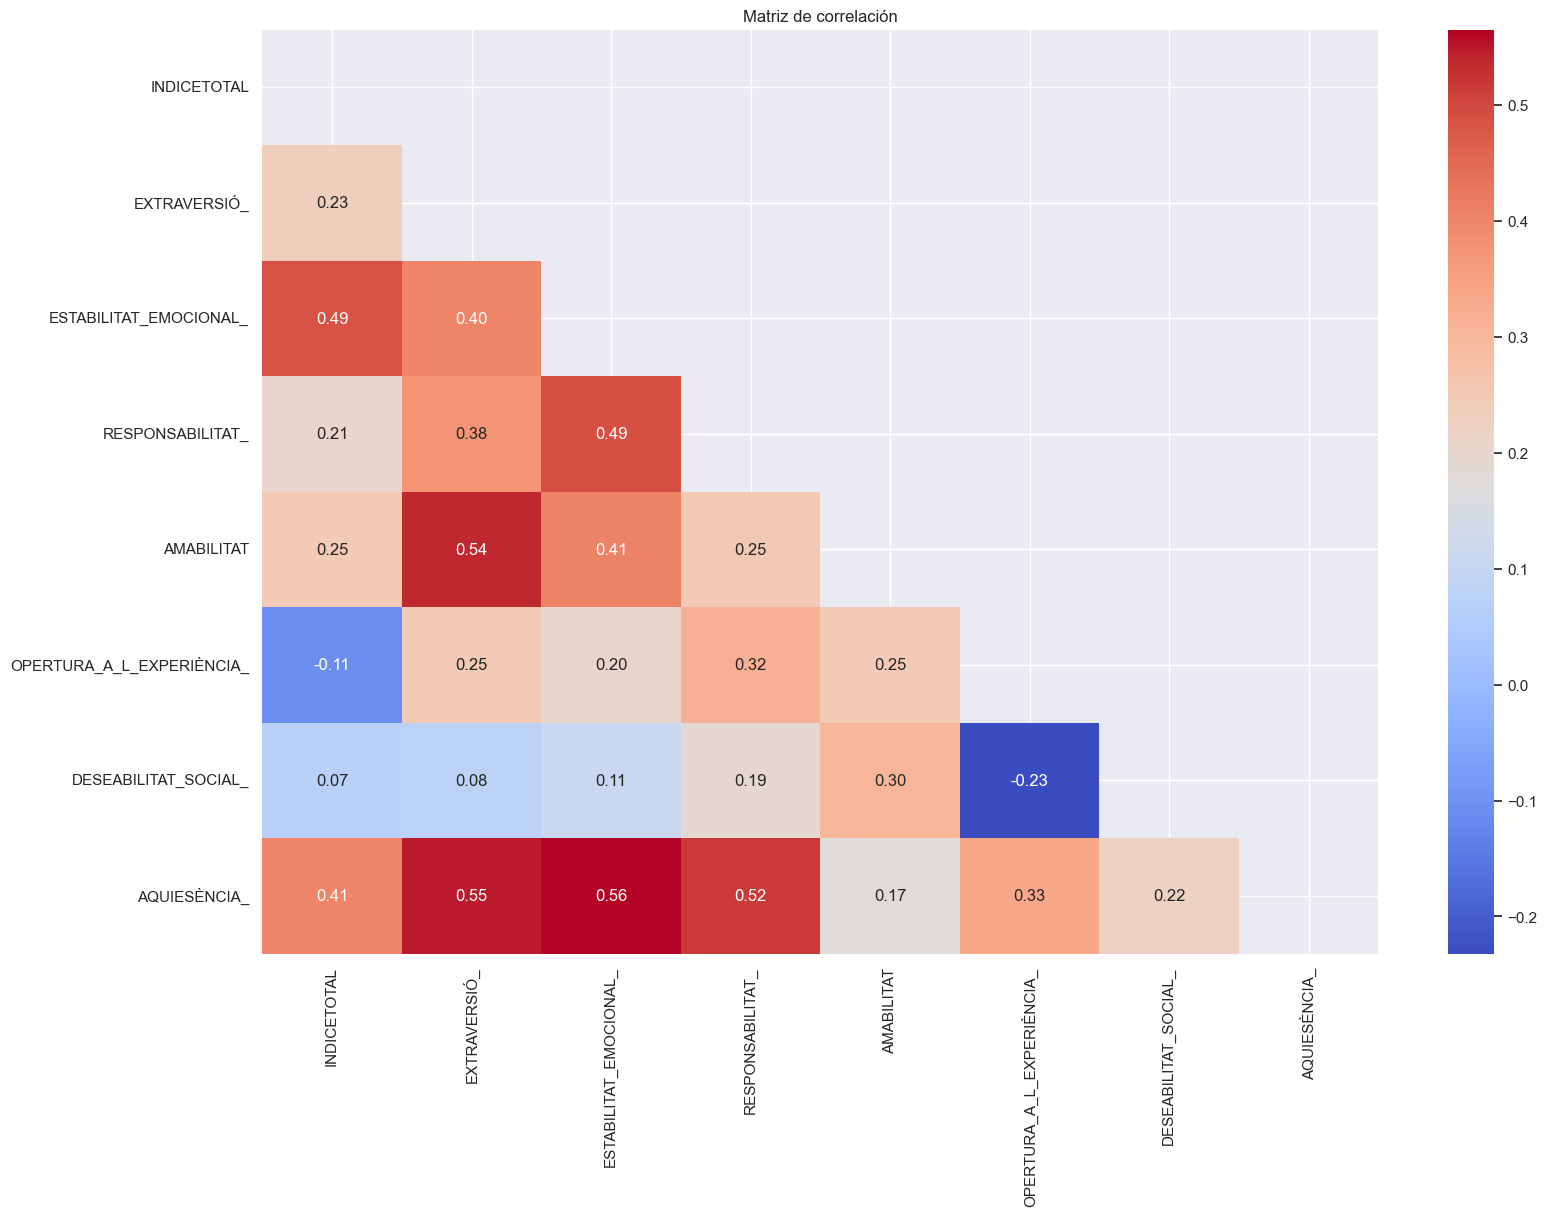

56 - 64, individuos:18


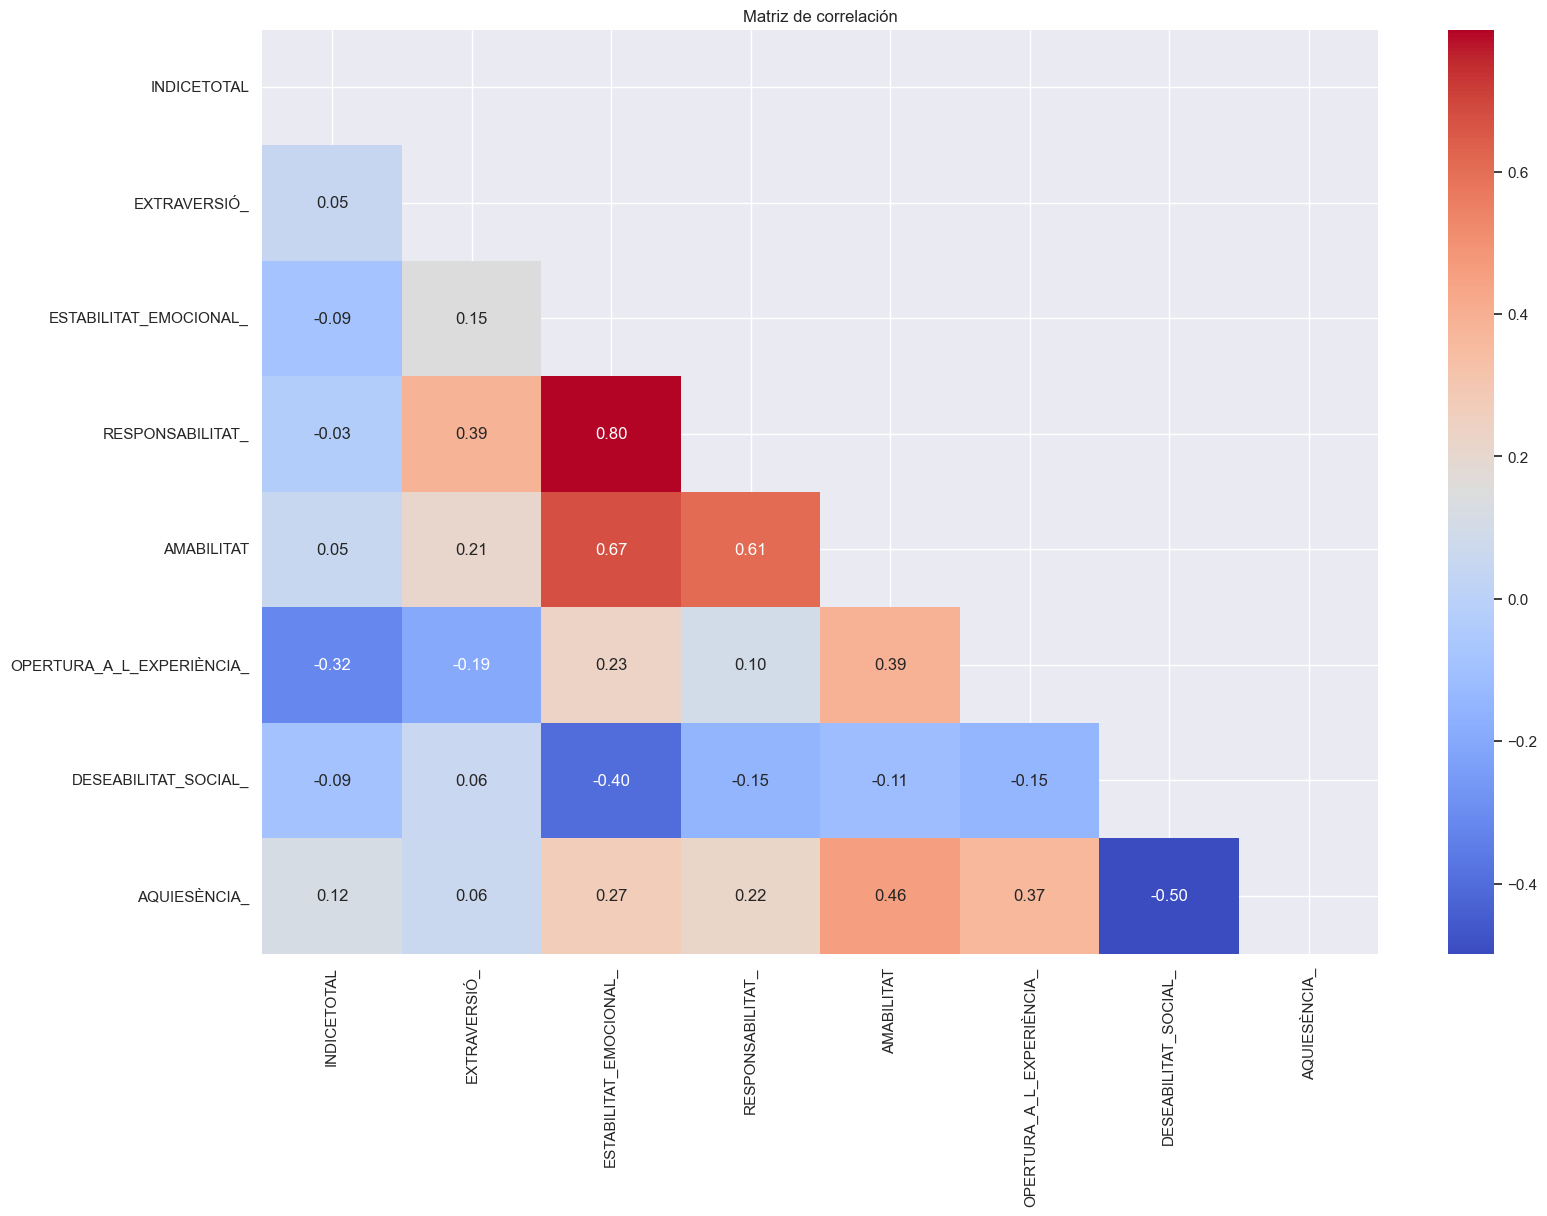

In [47]:
for edad, dataframe in dataframes_por_edad.items():
    # Obtener las variables varObj y datos_entrada para este DataFrame
    varObj = dataframe['INDICETOTAL']
    datos_entrada = dataframe.drop(columns=['INDICETOTAL'])  # Excluir la columna 'INDICETOTAL' de datos_entrada
    print(f'{edad}, individuos:{len(varObj)}')
    visualizar_matriz_correlacion(varObj, datos_entrada)

# COMPARACIÓN DE MEDIAS CON TEST T-STUDENT O ANOVA

La explicación teórica ídem al test ER

## T-STUDENT: GÉNERO

### Normalidad: Komogorov-Smirnov

In [48]:
total_mujeres = data_total[data_total['Género'] == 'Mujer']['INDICE TOTAL']
total_hombres = data_total[data_total['Género'] == 'Hombre']['INDICE TOTAL']


# Escalar las muestras utilizando StandardScaler
scaler = StandardScaler()
total_mujeres_scaled = scaler.fit_transform(total_mujeres.values.reshape(-1, 1)).flatten()
total_hombres_scaled = scaler.fit_transform(total_hombres.values.reshape(-1, 1)).flatten()

# Aplicar prueba KS a total_mujeres
statistic_mujeres, pvalue_mujeres = stats.kstest(total_mujeres_scaled, 'norm')
print("Resultados para total_mujeres:")
print(f"Estadístico: {statistic_mujeres}, Valor p: {pvalue_mujeres}")
if pvalue_mujeres > 0.05:
    print("La muestra de mujeres sigue una distribución normal")
else:
    print("La muestra de mujeres no sigue una distribución normal")

# Aplicar prueba KS a total_hombres
statistic_hombres, pvalue_hombres = stats.kstest(total_hombres_scaled, 'norm')
print("\nResultados para total_hombres:")
print(f"Estadístico: {statistic_hombres}, Valor p: {pvalue_hombres}")
if pvalue_hombres > 0.05:
    print("La muestra de hombres sigue una distribución normal")
else:
    print("La muestra de hombres no sigue una distribución normal")

Resultados para total_mujeres:
Estadístico: 0.10343162972075859, Valor p: 0.23384746295075176
La muestra de mujeres sigue una distribución normal

Resultados para total_hombres:
Estadístico: 0.11673556652598338, Valor p: 0.45624079841313236
La muestra de hombres sigue una distribución normal


### Homocedasticidad: Levenne

In [49]:
submuestra1l = total_hombres.values
submuestra2l = total_mujeres.values


# Nivel de significancia (alfa)
alfa = 0.05

df_grupo1 = len(submuestra1l) - 1
df_grupo2 = len(submuestra2l) - 1
# Calcular los valores críticos
valor_critico1le = np.percentile(np.random.f(df_grupo1, df_grupo2, size=10000), (1 - alfa / 2) * 100)
valor_critico2le = np.percentile(np.random.f(df_grupo1, df_grupo2, size=10000), (alfa / 2) * 100)


estadistico_levene, p_valor = levene(submuestra1l, submuestra2l)

print("Valor crítico superior:", valor_critico1le)
print("Valor crítico inferior:", valor_critico2le)

print("Estadístico de Levene:", estadistico_levene)
print("Valor p:", p_valor)

# Comparar el p-valor con el nivel de significancia (por ejemplo, 0.05) para tomar decisiones
nivel_significancia = 0.05
if p_valor < nivel_significancia:
    print("Rechazar la hipótesis nula. Hay evidencia de diferencias significativas en las varianzas.")
else:
    print("No se puede rechazar la hipótesis nula. No hay suficiente evidencia para afirmar diferencias significativas en las varianzas.")

Valor crítico superior: 1.6068480343519247
Valor crítico inferior: 0.6049652330851627
Estadístico de Levene: 0.5388308192770782
Valor p: 0.4640948815753251
No se puede rechazar la hipótesis nula. No hay suficiente evidencia para afirmar diferencias significativas en las varianzas.


### T-STUDENT

In [50]:
n1=len(total_hombres)
n2=len(total_mujeres)
grados_libertad = n1+n2-2
diferencia_medias=total_hombres.mean()-total_mujeres.mean()

s1=np.var(total_hombres)
s2=np.var(total_mujeres)
error_standar  = mt.sqrt((((n1*mt.pow(s1,2)+n2*mt.pow(s2,2))*((1/n1)+(1/n2)))/(grados_libertad)))

from scipy.stats import t
#calcularemos los valores cirticos correspondeintes a la distribucion T
alfa = 0.05
alfa_medios = alfa/2

lim_sup = t.ppf(1-alfa_medios,grados_libertad)
lim_inf = t.ppf(alfa_medios,grados_libertad)

print("la zona de aceptacion para la prueba es :",lim_inf,",",lim_sup)

t_observado= float(diferencia_medias)/(error_standar)

print("el valor critico de T es :", t_observado)

la zona de aceptacion para la prueba es : -1.9763456545827007 , 1.9763456545827003
el valor critico de T es : -0.07453662069869542


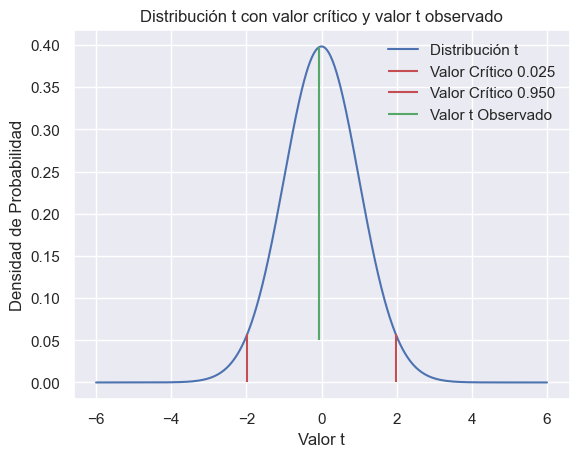

In [51]:
# Definir el rango de valores de t
t_values = np.linspace(-6, 6, 1000)

# Calcular la distribución t
t_distribucion = t.pdf(t_values, grados_libertad)

# Graficar la distribución t
plt.plot(t_values, t_distribucion, label='Distribución t')

# Graficar el valor crítico y el valor t observado
plt.vlines(lim_inf, 0, t.pdf(lim_inf, grados_libertad), colors='r', label='Valor Crítico 0.025')
plt.vlines(lim_sup, 0, t.pdf(lim_sup, grados_libertad), colors='r', label='Valor Crítico 0.950')

plt.vlines( -0.070, 0.05, t.pdf( -0.070, grados_libertad), colors='g', label='Valor t Observado')

# Configurar la leyenda y etiquetas
plt.legend()
plt.xlabel('Valor t')
plt.ylabel('Densidad de Probabilidad')
plt.title('Distribución t con valor crítico y valor t observado')

plt.show()

## ANOVA: EDAD

### Normalidad: Komogorov-Smirnov

In [52]:
def prueba_ks_edades(datos, edad):

    # Obtener la muestra para el rango de edad actual
    muestra = data_total[data_total['Edad'] == edad]['INDICE TOTAL']

    # Escalar la muestra utilizando StandardScaler
    scaler = StandardScaler()
    muestra_scaled = scaler.fit_transform(muestra.values.reshape(-1, 1)).flatten()

    # Aplicar prueba KS a la muestra
    statistic, pvalue = stats.kstest(muestra_scaled, 'norm')

    # Imprimir los resultados
    print(f"Resultados para el rango de edad {edad}:")
    print(f"Estadístico KS: {statistic}, Valor p: {pvalue}")
    if pvalue > 0.05:
        print(f"La muestra de {edad} sigue una distribución normal")
    else:
        print(f"La muestra de {edad} no sigue una distribución normal")
    print()

rangos_edad = ['18 - 25', '26 - 35', '36 - 45', '46 - 55', '56 - 64']

for rango_edad in rangos_edad:
    prueba_ks_edades(data_total, rango_edad)

Resultados para el rango de edad 18 - 25:
Estadístico KS: 0.08011731698072355, Valor p: 0.5960394585596063
La muestra de 18 - 25 sigue una distribución normal

Resultados para el rango de edad 26 - 35:
Estadístico KS: 0.12814212911036515, Valor p: 0.9892337011899457
La muestra de 26 - 35 sigue una distribución normal

Resultados para el rango de edad 36 - 45:
Estadístico KS: 0.1740606798787127, Valor p: 0.6552209515445536
La muestra de 36 - 45 sigue una distribución normal

Resultados para el rango de edad 46 - 55:
Estadístico KS: 0.1848728663046343, Valor p: 0.5819074263705921
La muestra de 46 - 55 sigue una distribución normal

Resultados para el rango de edad 56 - 64:
Estadístico KS: 0.1411467986955589, Valor p: 0.8180127785886622
La muestra de 56 - 64 sigue una distribución normal



### Homocedasticidad: Levenne

In [53]:
data_total['Edad'].unique()

array(['18 - 25', '46 - 55', '26 - 35', '56 - 64', '36 - 45'],
      dtype=object)

In [54]:
total_18_25 = data_total[data_total['Edad'] == '18 - 25']['INDICE TOTAL']
total_26_35 = data_total[data_total['Edad'] == '26 - 35']['INDICE TOTAL']
total_36_45 = data_total[data_total['Edad'] == '36 - 45']['INDICE TOTAL']
total_46_55 = data_total[data_total['Edad'] == '46 - 55']['INDICE TOTAL']
total_56_65 = data_total[data_total['Edad'] == '56 - 64']['INDICE TOTAL']

submuestra1l = total_18_25.values
submuestra2l = total_26_35.values
submuestra3l = total_36_45.values
submuestra4l = total_46_55.values
submuestra5l = total_56_65.values

# Aplicar la prueba de Levene
estadistico_levene, p_valor = levene(submuestra1l, submuestra2l, submuestra3l, submuestra4l, submuestra5l)

print("Estadístico de Levene:", estadistico_levene)
print("Valor p:", p_valor)

# Comparar el p-valor con el nivel de significancia (por ejemplo, 0.05) para tomar decisiones
nivel_significancia = 0.05
if p_valor < nivel_significancia:
    print("Rechazar la hipótesis nula. Hay evidencia de diferencias significativas en las varianzas.")
else:
    print("No se puede rechazar la hipótesis nula. No hay suficiente evidencia para afirmar diferencias significativas en las varianzas.")

Estadístico de Levene: 5.10419160667808
Valor p: 0.0007126863711043513
Rechazar la hipótesis nula. Hay evidencia de diferencias significativas en las varianzas.


No podemos aceptar la homocedasticidad, por tanto, no podemos aplicar ANOVA y deberíamos aplicar una prueba NO PARAMÉTRICA.

### ANOVA

Cuando la homocedasticidad no se cumple, una alternativa común a la Prueba ANOVA es la Prueba de Kruskal-Wallis. Esta prueba es una versión no paramétrica del ANOVA y se utiliza para determinar si hay diferencias significativas entre tres o más grupos independientes en una variable ordinal o continua.

In [55]:
from scipy.stats import kruskal

total_18_25 = data_total[data_total['Edad'] == '18 - 25']['INDICE TOTAL']
total_26_35 = data_total[data_total['Edad'] == '26 - 35']['INDICE TOTAL']
total_36_45 = data_total[data_total['Edad'] == '36 - 45']['INDICE TOTAL']
total_46_55 = data_total[data_total['Edad'] == '46 - 55']['INDICE TOTAL']
total_56_65 = data_total[data_total['Edad'] == '56 - 64']['INDICE TOTAL']

submuestra1l = total_18_25.values
submuestra2l = total_26_35.values
submuestra3l = total_36_45.values
submuestra4l = total_46_55.values
submuestra5l = total_56_65.values

# Aplicar la prueba de Kruskal-Wallis
statistic, p_value = kruskal(submuestra1l, submuestra2l, submuestra3l, submuestra4l, submuestra5l)

# Imprimir los resultados
print("Estadístico de prueba (H):", statistic)
print("Valor p:", p_value)

# Comprobamos si el resultado es significativo (usualmente con un nivel de significancia de 0.05)
if p_value < 0.05:
    print("Hay diferencias significativas entre al menos un par de grupos.")
else:
    print("No hay evidencia suficiente para rechazar la hipótesis nula de igualdad de medianas entre los grupos.")

Estadístico de prueba (H): 17.481082813948706
Valor p: 0.0015581676912674199
Hay diferencias significativas entre al menos un par de grupos.


In [56]:
import scikit_posthocs as sp

# Crear un diccionario con las muestras de cada grupo
muestras = {
    '18-25': submuestra1l,
    '26-35': submuestra2l,
    '36-45': submuestra3l,
    '46-55': submuestra4l,
    '56-64': submuestra5l
}

# Aplicar la prueba de Dunn

resultados_dunn=sp.posthoc_conover(data_total, val_col='INDICE TOTAL', group_col='Edad', p_adjust = 'holm')

# Mostrar la matriz de comparaciones
print(resultados_dunn)

          18 - 25   26 - 35   36 - 45   46 - 55  56 - 64
18 - 25  1.000000  0.080374  0.144649  0.091347  0.04333
26 - 35  0.080374  1.000000  1.000000  1.000000  1.00000
36 - 45  0.144649  1.000000  1.000000  1.000000  1.00000
46 - 55  0.091347  1.000000  1.000000  1.000000  1.00000
56 - 64  0.043330  1.000000  1.000000  1.000000  1.00000


## ANOVA: OCUPACIÓN ACTUAL

### Normalidad: Komogorov-Smirnov

In [57]:
def prueba_ks_nivel(datos, nivel):

    # Obtener la muestra para el rango de edad actual
    muestra = data_total[data_total['Ocupación actual'] == nivel]['INDICE TOTAL']

    # Escalar la muestra utilizando StandardScaler
    scaler = StandardScaler()
    muestra_scaled = scaler.fit_transform(muestra.values.reshape(-1, 1)).flatten()

    # Aplicar prueba KS a la muestra
    statistic, pvalue = stats.kstest(muestra_scaled, 'norm')

    # Imprimir los resultados
    print(f"Resultados para el rango de edad {nivel}:")
    print(f"Estadístico KS: {statistic}, Valor p: {pvalue}")
    if pvalue > 0.05:
        print(f"La muestra de {nivel} sigue una distribución normal")
    else:
        print(f"La muestra de {nivel} no sigue una distribución normal")
    print()

rangos_nivel = ['Estudiante', 'Empleado', 'Estudiante + trabajador', 'Desempleado']

for rango_nivel in rangos_nivel:
    prueba_ks_nivel(data_total, rango_nivel)

Resultados para el rango de edad Estudiante:
Estadístico KS: 0.14964555086890852, Valor p: 0.20118164669849226
La muestra de Estudiante sigue una distribución normal

Resultados para el rango de edad Empleado:
Estadístico KS: 0.11822114972868064, Valor p: 0.5896890942231364
La muestra de Empleado sigue una distribución normal

Resultados para el rango de edad Estudiante + trabajador:
Estadístico KS: 0.13451218473456483, Valor p: 0.39763884721938336
La muestra de Estudiante + trabajador sigue una distribución normal

Resultados para el rango de edad Desempleado:
Estadístico KS: 0.1417575870347974, Valor p: 0.8380431668175592
La muestra de Desempleado sigue una distribución normal



### Homocedasticidad: Levenne

In [58]:
total_Estudiante = data_total[data_total['Ocupación actual'] == 'Estudiante']['INDICE TOTAL']
total_Empleado = data_total[data_total['Ocupación actual'] == 'Empleado']['INDICE TOTAL']
total_E_T = data_total[data_total['Ocupación actual'] == 'Estudiante + trabajador']['INDICE TOTAL']
total_Desempleado= data_total[data_total['Ocupación actual'] == 'Desempleado']['INDICE TOTAL']

submuestra1l = total_Estudiante.values
submuestra2l = total_Empleado.values
submuestra3l = total_E_T.values
submuestra4l = total_Desempleado.values

# Aplicar la prueba de Levene
estadistico_levene, p_valor = levene(submuestra1l, submuestra2l, submuestra3l,submuestra4l)

print("Estadístico de Levene:", estadistico_levene)
print("Valor p:", p_valor)

# Comparar el p-valor con el nivel de significancia (por ejemplo, 0.05) para tomar decisiones
nivel_significancia = 0.05
if p_valor < nivel_significancia:
    print("Rechazar la hipótesis nula. Hay evidencia de diferencias significativas en las varianzas.")
else:
    print("No se puede rechazar la hipótesis nula. No hay suficiente evidencia para afirmar diferencias significativas en las varianzas.")

Estadístico de Levene: 3.53727635713339
Valor p: 0.01637303969265088
Rechazar la hipótesis nula. Hay evidencia de diferencias significativas en las varianzas.


### ANOVA

In [59]:
total_Estudiante = data_total[data_total['Ocupación actual'] == 'Estudiante']['INDICE TOTAL']
total_Empleado = data_total[data_total['Ocupación actual'] == 'Empleado']['INDICE TOTAL']
total_E_T = data_total[data_total['Ocupación actual'] == 'Estudiante + trabajador']['INDICE TOTAL']
total_Desempleado= data_total[data_total['Ocupación actual'] == 'Desempleado']['INDICE TOTAL']

submuestra1l = total_Estudiante.values
submuestra2l = total_Empleado.values
submuestra3l = total_E_T.values
submuestra4l = total_Desempleado.values

# Aplicar la prueba de Kruskal-Wallis
statistic, p_value = kruskal(submuestra1l, submuestra2l, submuestra3l,submuestra4l)

# Imprimir los resultados
print("Estadístico de prueba (H):", statistic)
print("Valor p:", p_value)

# Comprobamos si el resultado es significativo (usualmente con un nivel de significancia de 0.05)
if p_value < 0.05:
    print("Hay diferencias significativas entre al menos un par de grupos.")
else:
    print("No hay evidencia suficiente para rechazar la hipótesis nula de igualdad de medianas entre los grupos.")

Estadístico de prueba (H): 11.93257710367583
Valor p: 0.007617727901424938
Hay diferencias significativas entre al menos un par de grupos.


In [60]:
# Crear un diccionario con las muestras de cada grupo
muestras = {
    'Estudiante': submuestra1l,
    'Empleado': submuestra2l,
    'Estudiante + trabajador': submuestra3l,
    'Desempleado': submuestra4l,
}

# Aplicar la prueba de Dunn

resultados_dunn=sp.posthoc_conover(data_total, val_col='INDICE TOTAL', group_col='Ocupación actual', p_adjust = 'holm')

# Mostrar la matriz de comparaciones
resultados_dunn

,Desempleado,Empleado,Estudiante,Estudiante + trabajador
Desempleado,1.000000,0.572557,0.023498,0.456745
Empleado,0.572557,1.000000,0.021495,0.572557
Estudiante,0.023498,0.021495,1.000000,0.250401
Estudiante + trabajador,0.456745,0.572557,0.250401,1.000000


## ANOVA: NIVEL DE ESTUDIOS

### Normalidad: Komogorov-Smirnov

In [61]:
def prueba_ks_nivel(datos, nivel):

    # Obtener la muestra para el rango de edad actual
    muestra = data_total[data_total['Nivel de estudios logrados 2'] == nivel]['INDICE TOTAL']

    # Escalar la muestra utilizando StandardScaler
    scaler = StandardScaler()
    muestra_scaled = scaler.fit_transform(muestra.values.reshape(-1, 1)).flatten()

    # Aplicar prueba KS a la muestra
    statistic, pvalue = stats.kstest(muestra_scaled, 'norm')

    # Imprimir los resultados
    print(f"Resultados para el rango de edad {nivel}:")
    print(f"Estadístico KS: {statistic}, Valor p: {pvalue}")
    if pvalue > 0.05:
        print(f"La muestra de {nivel} sigue una distribución normal")
    else:
        print(f"La muestra de {nivel} no sigue una distribución normal")
    print()

rangos_nivel = ['Superior', 'Intermedia', 'Obligatoria']

for rango_nivel in rangos_nivel:
    prueba_ks_nivel(data_total, rango_nivel)

Resultados para el rango de edad Superior:
Estadístico KS: 0.12015323858474586, Valor p: 0.5248607805494846
La muestra de Superior sigue una distribución normal

Resultados para el rango de edad Intermedia:
Estadístico KS: 0.15520923835528533, Valor p: 0.031142829343070444
La muestra de Intermedia no sigue una distribución normal

Resultados para el rango de edad Obligatoria:
Estadístico KS: 0.15076857762604556, Valor p: 0.671679654069548
La muestra de Obligatoria sigue una distribución normal



Para el rango de edad Intermedia observamos que no sigue una distribución normal. 

### Homocedasticidad: Levenne

In [62]:
total_Superior = data_total[data_total['Nivel de estudios logrados 2'] == 'Superior']['INDICE TOTAL']
total_Intermedia = data_total[data_total['Nivel de estudios logrados 2'] == 'Intermedia']['INDICE TOTAL']
total_Obligatoria = data_total[data_total['Nivel de estudios logrados 2'] == 'Obligatoria']['INDICE TOTAL']

submuestra1l = total_Superior.values
submuestra2l = total_Intermedia.values
submuestra3l = total_Obligatoria.values


# Aplicar la prueba de Levene
estadistico_levene, p_valor = levene(submuestra1l, submuestra2l, submuestra3l)

print("Estadístico de Levene:", estadistico_levene)
print("Valor p:", p_valor)

# Comparar el p-valor con el nivel de significancia (por ejemplo, 0.05) para tomar decisiones
nivel_significancia = 0.05
if p_valor < nivel_significancia:
    print("Rechazar la hipótesis nula. Hay evidencia de diferencias significativas en las varianzas.")
else:
    print("No se puede rechazar la hipótesis nula. No hay suficiente evidencia para afirmar diferencias significativas en las varianzas.")

Estadístico de Levene: 0.2088040355229065
Valor p: 0.8117978459705637
No se puede rechazar la hipótesis nula. No hay suficiente evidencia para afirmar diferencias significativas en las varianzas.


### ANOVA

In [63]:
pg.anova(data=data_total,dv='INDICE TOTAL',between='Nivel de estudios logrados 2',detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,Nivel de estudios logrados 2,3417.881656,2,1708.940828,3.820376,0.024158,0.050057
1,Within,64861.794020,145,447.322717,NaN,NaN,NaN


In [64]:
total_Superior = data_total[data_total['Nivel de estudios logrados 2'] == 'Superior']['INDICE TOTAL']
total_Intermedia = data_total[data_total['Nivel de estudios logrados 2'] == 'Intermedia']['INDICE TOTAL']
total_Obligatoria = data_total[data_total['Nivel de estudios logrados 2'] == 'Obligatoria']['INDICE TOTAL']

submuestra1l = total_Superior.values
submuestra2l = total_Intermedia.values
submuestra3l = total_Obligatoria.values

# Aplicar la prueba de Kruskal-Wallis
statistic, p_value = kruskal(submuestra1l, submuestra2l, submuestra3l)

# Imprimir los resultados
print("Estadístico de prueba (H):", statistic)
print("Valor p:", p_value)

# Comprobamos si el resultado es significativo (usualmente con un nivel de significancia de 0.05)
if p_value < 0.05:
    print("Hay diferencias significativas entre al menos un par de grupos.")
else:
    print("No hay evidencia suficiente para rechazar la hipótesis nula de igualdad de medianas entre los grupos.")

Estadístico de prueba (H): 7.321081562672773
Valor p: 0.025718600825726353
Hay diferencias significativas entre al menos un par de grupos.


In [65]:
# Crear un diccionario con las muestras de cada grupo
muestras = {
    'Superior': submuestra1l,
    'Intermedia': submuestra2l,
    'Obligatoria': submuestra3l,
}

# Aplicar la prueba de Dunn

resultados_dunn=sp.posthoc_conover(data_total, val_col='INDICE TOTAL', group_col='Nivel de estudios logrados 2', p_adjust = 'holm')

# Mostrar la matriz de comparaciones
print(resultados_dunn)

             Intermedia  Obligatoria  Superior
Intermedia     1.000000     0.028526  0.626340
Obligatoria    0.028526     1.000000  0.028526
Superior       0.626340     0.028526  1.000000
